<a href="https://colab.research.google.com/github/Cumberkid/Learning-the-Optimal-Solution-Path/blob/main/Learning_the_Optimal_Solution_Path_vs_Naive_Grid_Search_using_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import the necessary libraries

In [1]:
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader  #for creating the dataset


device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using device: {device}")

Using device: cuda


In [2]:
import matplotlib.pyplot as plt

In [3]:
import pandas as pd

In [4]:
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

In [5]:
!wget -O helpers.py https://raw.githubusercontent.com/Cumberkid/Learning-the-Optimal-Solution-Path/main/helpers.py

import helpers

--2023-11-26 06:40:41--  https://raw.githubusercontent.com/Cumberkid/Learning-the-Optimal-Solution-Path/main/helpers.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2345 (2.3K) [text/plain]
Saving to: ‘helpers.py’

helpers.py          100%[===================>]   2.29K  --.-KB/s    in 0s      

2023-11-26 06:40:41 (38.6 MB/s) - ‘helpers.py’ saved [2345/2345]



In [6]:
!wget -O NGS.py https://raw.githubusercontent.com/Cumberkid/Learning-the-Optimal-Solution-Path/main/NGS.py

import NGS

--2023-11-26 06:40:41--  https://raw.githubusercontent.com/Cumberkid/Learning-the-Optimal-Solution-Path/main/NGS.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9161 (8.9K) [text/plain]
Saving to: ‘NGS.py’

NGS.py              100%[===================>]   8.95K  --.-KB/s    in 0s      

2023-11-26 06:40:42 (69.4 MB/s) - ‘NGS.py’ saved [9161/9161]

Using device: cuda


In [7]:
!wget -O SGD.py https://raw.githubusercontent.com/Cumberkid/Learning-the-Optimal-Solution-Path/main/SGD.py

import SGD

--2023-11-26 06:40:42--  https://raw.githubusercontent.com/Cumberkid/Learning-the-Optimal-Solution-Path/main/SGD.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4938 (4.8K) [text/plain]
Saving to: ‘SGD.py’

SGD.py              100%[===================>]   4.82K  --.-KB/s    in 0s      

2023-11-26 06:40:42 (64.0 MB/s) - ‘SGD.py’ saved [4938/4938]



# Preliminaries

## Dataset
We use the Wisconsin breast cancer dataset and then port it over an object of the Pytorch dataset class so it can be read by data_loader.

Description of the breast cancer Wisconsin dataset (classification): https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_breast_cancer.html#sklearn.datasets.load_breast_cancer

In [8]:
from sklearn.datasets import load_breast_cancer

In [9]:
# load breast cancer data
X, y = load_breast_cancer(return_X_y=True)

In [10]:
df = pd.DataFrame(X).describe()

df

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,...,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,...,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,...,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,...,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,...,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,...,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,...,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


In [11]:
clf = LogisticRegression(solver='lbfgs', max_iter=100).fit(X[:100,:], y[:100])

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [12]:
clf.predict(X[:100,:])

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0,
       1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0,
       1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0])

In [13]:
# preprocess data
from sklearn.preprocessing import StandardScaler, RobustScaler

scaler = StandardScaler()
# scaler = RobustScaler()
scaler.fit(X)
X = scaler.transform(X)

In [14]:
df = pd.DataFrame(X).describe()

df

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
count,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,...,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02
mean,-3.153111e-15,-6.568462e-15,-6.993039e-16,-8.553985e-16,6.081447e-15,-1.136369e-15,-2.997017e-16,1.023981e-15,-1.860648e-15,-1.504752e-15,...,-2.297713e-15,1.742016e-15,-1.198807e-15,6.118909e-16,-5.094929e-15,-2.122887e-15,6.118909e-16,-1.998011e-16,-2.422589e-15,2.497514e-15
std,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,...,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00
min,-2.029648e+00,-2.229249e+00,-1.984504e+00,-1.454443e+00,-3.112085e+00,-1.610136e+00,-1.114873e+00,-1.261820e+00,-2.744117e+00,-1.819865e+00,...,-1.726901e+00,-2.223994e+00,-1.693361e+00,-1.222423e+00,-2.682695e+00,-1.443878e+00,-1.305831e+00,-1.745063e+00,-2.160960e+00,-1.601839e+00
25%,-6.893853e-01,-7.259631e-01,-6.919555e-01,-6.671955e-01,-7.109628e-01,-7.470860e-01,-7.437479e-01,-7.379438e-01,-7.032397e-01,-7.226392e-01,...,-6.749213e-01,-7.486293e-01,-6.895783e-01,-6.421359e-01,-6.912304e-01,-6.810833e-01,-7.565142e-01,-7.563999e-01,-6.418637e-01,-6.919118e-01
50%,-2.150816e-01,-1.046362e-01,-2.359800e-01,-2.951869e-01,-3.489108e-02,-2.219405e-01,-3.422399e-01,-3.977212e-01,-7.162650e-02,-1.782793e-01,...,-2.690395e-01,-4.351564e-02,-2.859802e-01,-3.411812e-01,-4.684277e-02,-2.695009e-01,-2.182321e-01,-2.234689e-01,-1.274095e-01,-2.164441e-01
75%,4.693926e-01,5.841756e-01,4.996769e-01,3.635073e-01,6.361990e-01,4.938569e-01,5.260619e-01,6.469351e-01,5.307792e-01,4.709834e-01,...,5.220158e-01,6.583411e-01,5.402790e-01,3.575891e-01,5.975448e-01,5.396688e-01,5.311411e-01,7.125100e-01,4.501382e-01,4.507624e-01
max,3.971288e+00,4.651889e+00,3.976130e+00,5.250529e+00,4.770911e+00,4.568425e+00,4.243589e+00,3.927930e+00,4.484751e+00,4.910919e+00,...,4.094189e+00,3.885905e+00,4.287337e+00,5.930172e+00,3.955374e+00,5.112877e+00,4.700669e+00,2.685877e+00,6.046041e+00,6.846856e+00


## Tuning the Learning Rate for Naive Grid Search

To gauge the performance of our model, we set up a benchmark with Naive Grid Search.

This method discretize the path over $\lambda \in [0,1]$ into a number of grids and trains a linear model on each grid.

Use the first 100 datapoints to select the best constant learning rate for Naive Grid Search. Make several plots of sup error along the solution path against learning rate using 500 iterations.

In [32]:
lr_list = 0.5 ** torch.arange(2, 13)
alpha_list = 0.5 ** torch.arange(-2, 11)
epochs = 500
input_dim = X.shape[1]
lam = 0.5
init_weight = torch.zeros(input_dim)
criterion = torch.nn.BCELoss()

In [33]:
# tune learning rate on the first 100 datapoints
tune_data = helpers.Regression_Data(X[:100, :], y[:100])
# full gradient descent uses all data points
tune_GD_data_loader = DataLoader(tune_data, batch_size=len(tune_data), shuffle=True, )
# stochastic gradient descent uses mini-batch
tune_SGD_data_loader = DataLoader(tune_data, batch_size=5, shuffle=True, )
# test data do not shuffle
tune_test_data_loader = DataLoader(tune_data, batch_size=len(tune_data), shuffle=False, )

###First, we tune full gradient descent.
For full gradient descent we use constant learning rate. We shall tune the learning rate directly.

In [ ]:
losses = []
for lr in lr_list:
    # train a model
    model = NGS.Logistic_Regression(input_dim, 1, lam, init_weight).to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    optimizer.zero_grad()

    for t in range(epochs):
        NGS.train(tune_GD_data_loader, model, criterion, optimizer, trace_frequency=5)

    loss = NGS.test(tune_test_data_loader, model, criterion, lam)

    print(f"learning rate: {lr}\t loss: {loss}")
    losses.append(loss)

learning rate: 0.25	 loss: 0.1987709105014801
learning rate: 0.125	 loss: 0.1987709403038025
learning rate: 0.0625	 loss: 0.1987709254026413
learning rate: 0.03125	 loss: 0.1987709403038025
learning rate: 0.015625	 loss: 0.1987711638212204
learning rate: 0.0078125	 loss: 0.19881215691566467
learning rate: 0.00390625	 loss: 0.1999007761478424
learning rate: 0.001953125	 loss: 0.207317516207695
learning rate: 0.0009765625	 loss: 0.22796867787837982
learning rate: 0.00048828125	 loss: 0.2595781087875366
learning rate: 0.000244140625	 loss: 0.29128414392471313


From the plot, we see that learning rate = $2^{-4}$ gives a low loss stably.

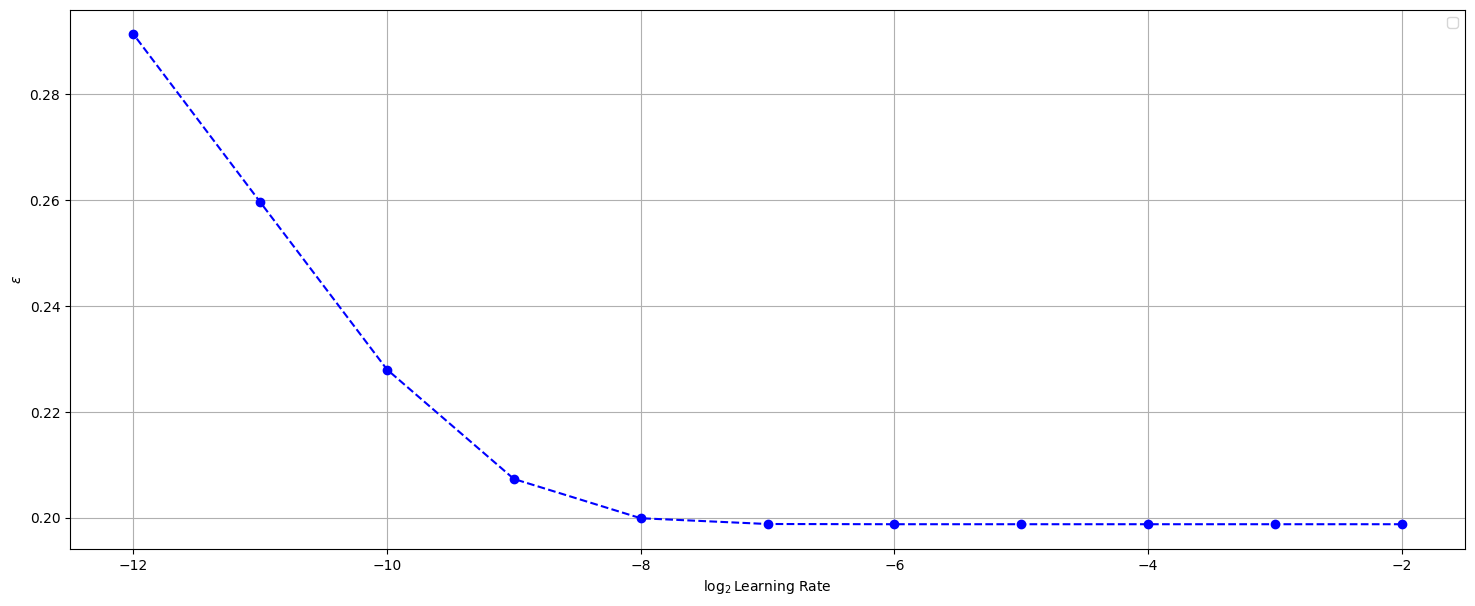

In [ ]:
# plot result of our method:
plt.figure(figsize=(18,7))
plt.plot(torch.log2(lr_list), torch.tensor(losses), '--bo')
plt.xlabel('$\\log_2$Learning Rate')
plt.ylabel("$\\epsilon$")
plt.legend()
plt.grid(True)

###Next, we tune stochastic gradient descent.

For stochastic gradient descent, we are using shrinking learning rate $\frac{\alpha}{T}$ for iteration $T$. We shall tune $\alpha$.

In [35]:
losses = []
for alpha in alpha_list:
    # train a model
    model = NGS.Logistic_Regression(input_dim, 1, lam, init_weight).to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
    optimizer.zero_grad()

    for t in range(epochs):
        # shrink learning rate
        lr = torch.min(torch.tensor([0.1, alpha/(t+1)]))
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr
        NGS.train(tune_GD_data_loader, model, criterion, optimizer, trace_frequency=5)

    loss = NGS.test(tune_test_data_loader, model, criterion, lam)

    print(f"alpha: {alpha}\t loss: {loss}")
    losses.append(loss)

alpha: 4.0	 loss: 0.1987709254026413
alpha: 2.0	 loss: 0.19877101480960846
alpha: 1.0	 loss: 0.1987801343202591
alpha: 0.5	 loss: 0.19901572167873383
alpha: 0.25	 loss: 0.20121613144874573
alpha: 0.125	 loss: 0.21042440831661224
alpha: 0.0625	 loss: 0.23303022980690002
alpha: 0.03125	 loss: 0.2659202516078949
alpha: 0.015625	 loss: 0.2966602146625519
alpha: 0.0078125	 loss: 0.3185037672519684
alpha: 0.00390625	 loss: 0.3316492736339569
alpha: 0.001953125	 loss: 0.33887380361557007
alpha: 0.0009765625	 loss: 0.3426622748374939


From the plot, we see that $\alpha = 2$ gives a low loss stably.

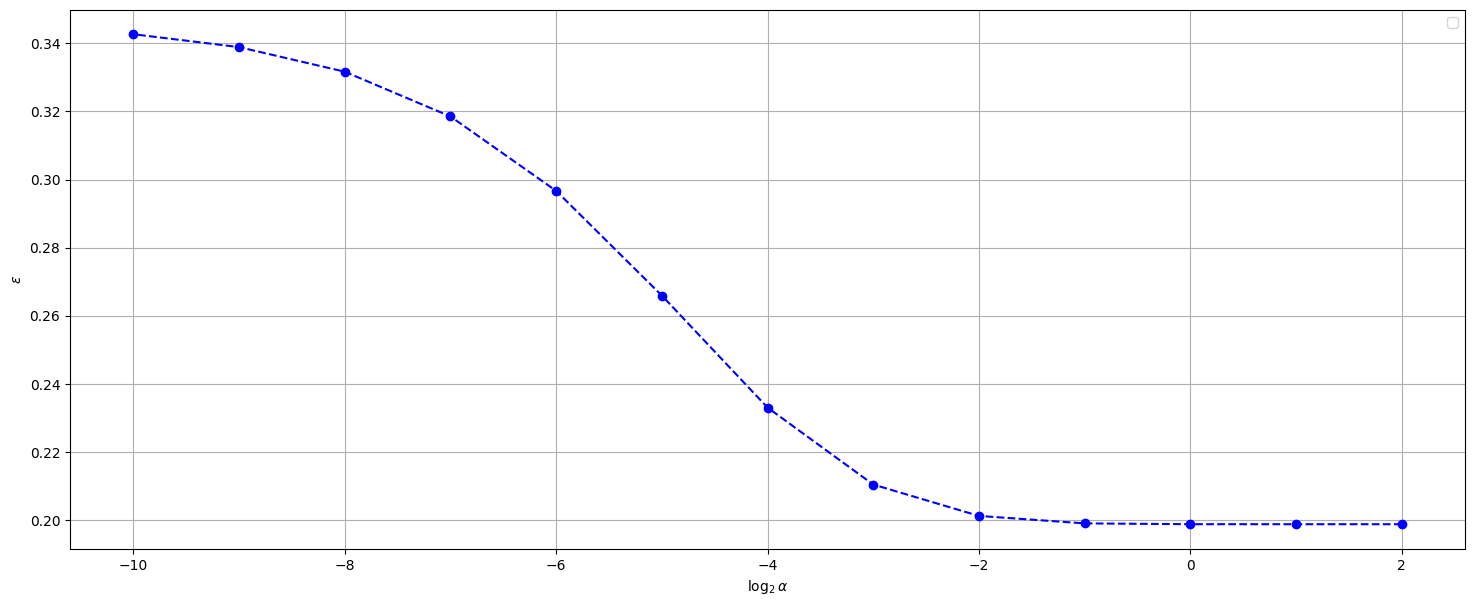

In [36]:
# plot result of our method:
plt.figure(figsize=(18,7))
plt.plot(torch.log2(alpha_list), losses, '--bo')
plt.xlabel('$\\log_2 \\alpha$')
plt.ylabel(f"$\\epsilon$")
plt.legend()
plt.grid(True)

## The True Solution Path

We use the Naive Grid Search with $2^{10}$ grids, trained by full gradient descent with learning rate = $2^{-4}$ and 5000 iterations on each grid, to generate a true solution path.

In [20]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [15]:
full_data = helpers.Regression_Data(X, y)
# full gradient descent uses all data points
GD_data_loader = DataLoader(full_data, batch_size=len(full_data), shuffle=True, )
# stochastic gradient descent uses mini-batch
SGD_data_loader = DataLoader(full_data, batch_size=5, shuffle=True, )
# test data
test_data_loader = DataLoader(full_data, batch_size=len(full_data), shuffle=False, )

In [16]:
lam_max = 1
lam_min = 0
input_dim = X.shape[1]
criterion=torch.nn.BCELoss()

In [17]:
num_grid = 2**10
delta_lam = (lam_max - lam_min)/num_grid
lambdas = torch.arange(lam_max, lam_min, (-1)*delta_lam)

In [18]:
# epochs = 5000
# lr = 0.5**4

In [21]:
# models, num_itr = NGS.naive_grid_search(lam_min=lam_min, lam_max=lam_max,
#                                     num_grid=num_grid, epochs=epochs, loss_fn=criterion,
#                                     trainDataLoader=GD_data_loader,
#                                     data_input_dim=input_dim,
#                                     lr=lr, SGD=False)

In [22]:
# losses = []
# for model in models:
#     losses.append(NGS.test(test_data_loader, model, criterion, model.reg_param))

In [23]:
# thetas = []
# for model in models:
#     thetas.append(model.linear.weight.data.cpu().detach().numpy()[0])
# thetas = np.array(thetas)
# print(thetas.shape)

(1024, 30)


In [24]:
# intercepts = []
# for model in models:
#     intercepts.append(model.linear.bias.data.cpu().detach().numpy()[0])
# intercepts = np.array(intercepts)
# print(intercepts.shape)

(1024,)


In [26]:
# import csv

# csv_file_path = '/content/drive/MyDrive/Experiments/exact_soln_list.csv'

# # Open the CSV file for writing
# with open(csv_file_path, 'w', newline='') as csv_file:
#     # Create a CSV writer
#     csv_writer = csv.writer(csv_file)

#     # Write the headers
#     csv_writer.writerow(['losses', 'theta_0', 'theta_1', 'theta_2', 'theta_3',
#                          'theta_4', 'theta_5', 'theta_6', 'theta_7', 'theta_8',
#                          'theta_9', 'theta_10', 'theta_11', 'theta_12', 'theta_13',
#                          'theta_14', 'theta_15', 'theta_16', 'theta_17', 'theta_18',
#                          'theta_19', 'theta_20', 'theta_21', 'theta_22', 'theta_23',
#                          'theta_24', 'theta_25', 'theta_26', 'theta_27', 'theta_28',
#                          'theta_29', 'theta_30'])

#     # Write the data from your lists
#     for i in range(num_grid):
#         csv_writer.writerow([losses[i], intercepts[i], thetas[i][0], thetas[i][1],
#                              thetas[i][2], thetas[i][3], thetas[i][4], thetas[i][5],
#                              thetas[i][6], thetas[i][7], thetas[i][8], thetas[i][9],
#                              thetas[i][10], thetas[i][11], thetas[i][12], thetas[i][13],
#                              thetas[i][14], thetas[i][15], thetas[i][16], thetas[i][17],
#                              thetas[i][18], thetas[i][19], thetas[i][20], thetas[i][21],
#                              thetas[i][22], thetas[i][23], thetas[i][24], thetas[i][25],
#                              thetas[i][26], thetas[i][27], thetas[i][28], thetas[i][29]])

In [31]:
csv_file_path = 'https://raw.githubusercontent.com/Cumberkid/Learning-the-Optimal-Solution-Path/main/exact_soln_list.csv'
truth = pd.read_csv(csv_file_path)
selected_columns = ['theta_0', 'theta_1', 'theta_2', 'theta_3', 'theta_4',
                    'theta_5', 'theta_6', 'theta_7', 'theta_8', 'theta_9',
                    'theta_10', 'theta_11', 'theta_12', 'theta_13', 'theta_14',
                    'theta_15', 'theta_16', 'theta_17', 'theta_18', 'theta_19',
                    'theta_20', 'theta_21', 'theta_22', 'theta_23', 'theta_24',
                    'theta_25', 'theta_26', 'theta_27', 'theta_28', 'theta_29',
                    'theta_30']
true_thetas = truth[selected_columns].to_numpy()
true_losses = truth['losses'].to_numpy()

#Learning the Solution Path Through SGD
Now, let us try running SGD over $Δλ$'s on a linear basis $\Phi(\lambda)$ of our choice. We now want to approximate $\theta$ with $\Phi(\lambda)\beta$, so the objective function becomes $h(\theta, \lambda) = (1-\lambda) BCE(X\Phi(\lambda)\beta,\ y) + \frac{\lambda}{2}\|\Phi(\lambda)\beta\|^2$. For each batch of training data set, we randomize $\lambda$. If batch size = 1, then this is equivalent to a standard SGD.

## Our Model

We use Legendre polynomials with degree $\leq 9$ as the basis vectors for $\Phi(\lambda)$.

In [36]:
full_data = helpers.Regression_Data(X, y)
# full gradient descent uses all data points
GD_data_loader = DataLoader(full_data, batch_size=len(full_data), shuffle=True, )
# stochastic gradient descent uses mini-batch
SGD_data_loader = DataLoader(full_data, batch_size=5, shuffle=True, )
# test data
test_data_loader = DataLoader(full_data, batch_size=len(full_data), shuffle=False, )

In [37]:
lam_max = 1
lam_min = 0
input_dim = X.shape[1]
criterion=torch.nn.BCELoss()

In [38]:
phi_lam = SGD.phi_lam_Legendre

In [39]:
criterion = torch.nn.BCELoss()
input_dim = X.shape[1]

## Tuning the learning rate for our model

In [138]:
lr_list = 0.5 ** torch.arange(2, 13)
alpha_list = 0.5 ** torch.arange(-2, 9)
epochs = 500
basis_dim = 13
lam = 0.5
criterion = torch.nn.BCELoss()

In [47]:
# tune learning rate on the first 100 datapoints
tune_data = helpers.Regression_Data(X[:100, :], y[:100])
# full gradient descent uses all data points
tune_GD_data_loader = DataLoader(tune_data, batch_size=len(tune_data), shuffle=True, )
# stochastic gradient descent uses mini-batch
tune_SGD_data_loader = DataLoader(tune_data, batch_size=5, shuffle=True, )
# test data do not shuffle
tune_test_data_loader = DataLoader(tune_data, batch_size=len(tune_data), shuffle=False, )

###First, we tune full gradient descent.
For full gradient descent we use constant learning rate. We shall tune the learning rate directly.

In [59]:
np.random.seed(8675309)
torch.manual_seed(8675309)

losses = []
for lr in lr_list:
    # train a model
    model = SGD.Basis_TF_SGD(input_dim, basis_dim, phi_lam, intercept=True).to(device)# reg_param = 0 here is only a space holder
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    optimizer.zero_grad()

    for t in range(epochs):
        SGD.train_SGD(tune_GD_data_loader, model, criterion, optimizer)

    loss = SGD.test_SGD(tune_test_data_loader, model, criterion, lam)

    print(f"learning rate: {lr}\t loss: {loss}")
    losses.append(loss)

learning rate: 0.25	 loss: 3.608082318293179e+28
learning rate: 0.125	 loss: 1.2264595031738281
learning rate: 0.0625	 loss: 0.1992998719215393
learning rate: 0.03125	 loss: 0.19877243041992188
learning rate: 0.015625	 loss: 0.1987711489200592
learning rate: 0.0078125	 loss: 0.19877833127975464
learning rate: 0.00390625	 loss: 0.20087231695652008
learning rate: 0.001953125	 loss: 0.20502528548240662
learning rate: 0.0009765625	 loss: 0.22526098787784576
learning rate: 0.00048828125	 loss: 0.25248000025749207
learning rate: 0.000244140625	 loss: 0.287759929895401


From the plot, we see that learning rate = $2^{-6}$ stably gives a low loss.

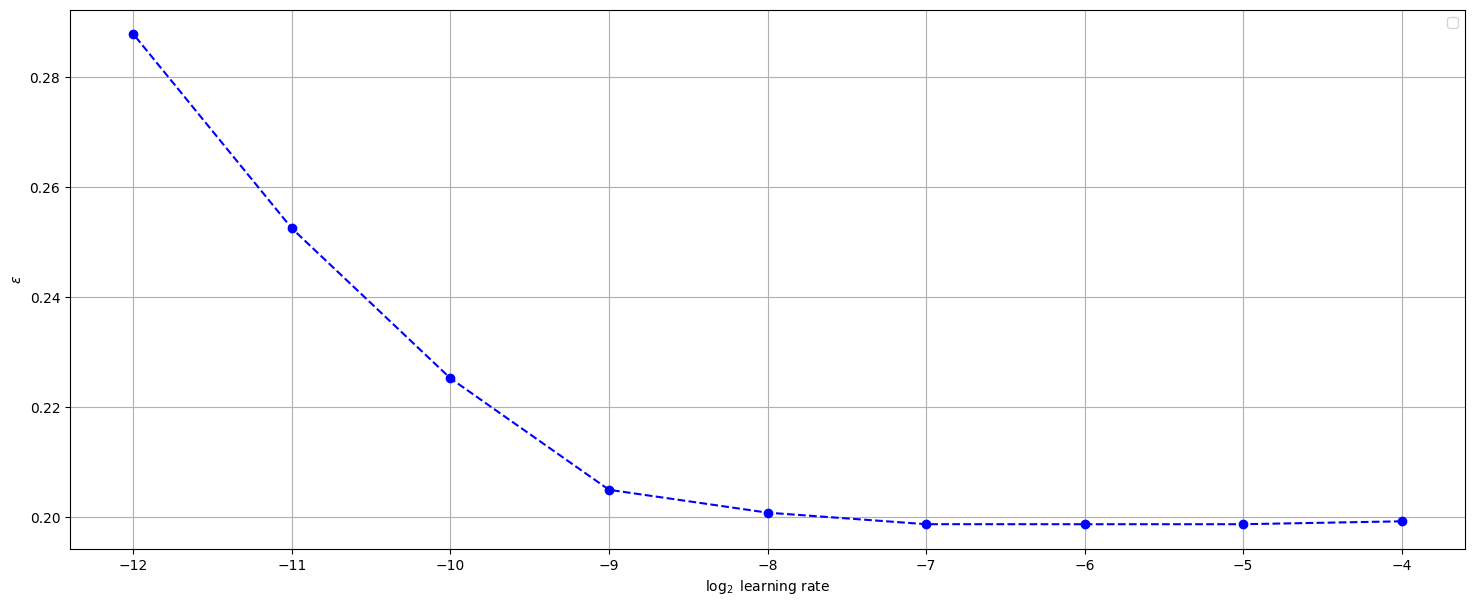

In [60]:
# plot result of our method:
plt.figure(figsize=(18,7))
plt.plot(torch.log2(lr_list[2:]), torch.tensor(losses[2:]), '--bo')
plt.xlabel('$\\log_2$ learning rate')
plt.ylabel(f"$\\epsilon$")
plt.legend()
plt.grid(True)

###Next, we tune stochastic gradient descent.

For stochastic gradient descent, we are using shrinking learning rate $\frac{\alpha}{T}$ for iteration $T$. We shall tune $\alpha$.

In [139]:
losses = []
for alpha in alpha_list:
    # train a model
    model = SGD.Basis_TF_SGD(input_dim, basis_dim, phi_lam, intercept=True).to(device)# reg_param = 0 here is only a space holder
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
    optimizer.zero_grad()

    for t in range(epochs):
        # shrink learning rate
        lr = torch.min(torch.tensor([0.01, alpha/(t+1)]))
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr
        SGD.train_SGD(tune_GD_data_loader, model, criterion, optimizer)

    loss = SGD.test_SGD(tune_test_data_loader, model, criterion, lam)

    print(f"alpha: {alpha}\t loss: {loss}")
    losses.append(loss)

alpha: 4.0	 loss: 0.19878239929676056
alpha: 2.0	 loss: 0.19880491495132446
alpha: 1.0	 loss: 0.19895656406879425
alpha: 0.5	 loss: 0.20127013325691223
alpha: 0.25	 loss: 0.21106764674186707
alpha: 0.125	 loss: 0.2348201423883438
alpha: 0.0625	 loss: 0.2426881492137909
alpha: 0.03125	 loss: 0.24519099295139313
alpha: 0.015625	 loss: 0.3084656000137329
alpha: 0.0078125	 loss: 0.3179720938205719
alpha: 0.00390625	 loss: 0.3371119499206543


From the plot, we see that $\alpha = 1$ stably yields low loss.



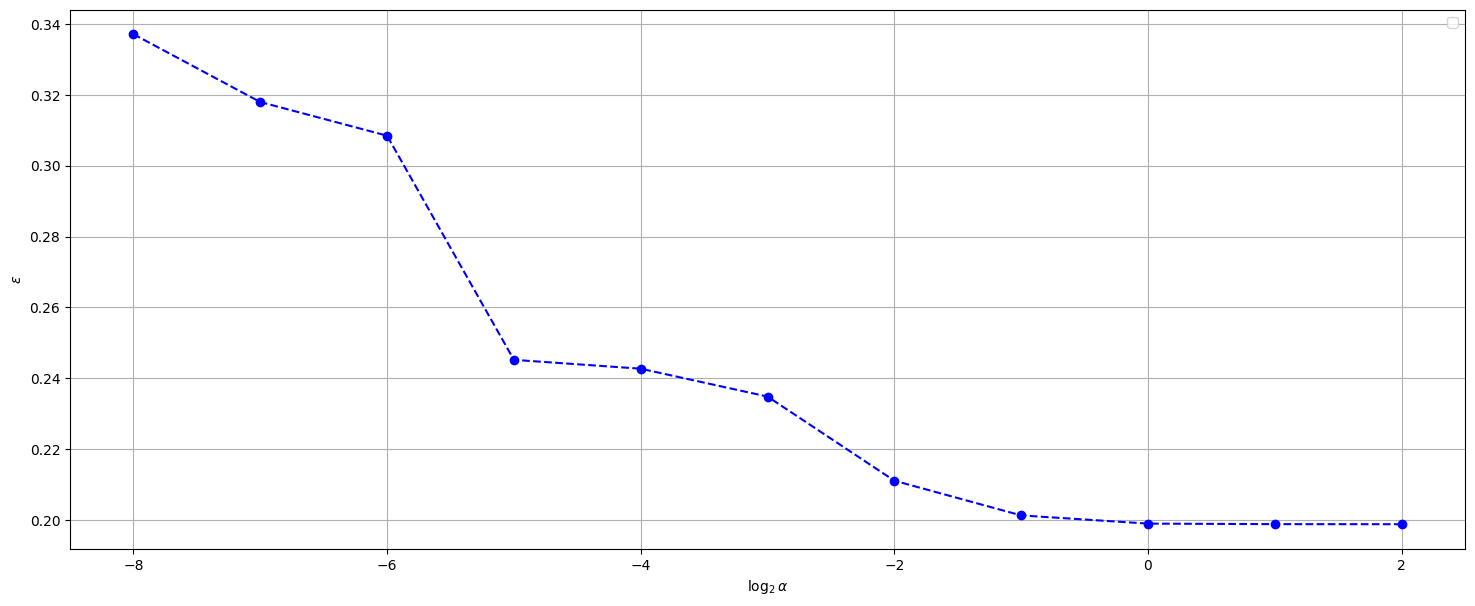

In [140]:
# plot result of our method:
plt.figure(figsize=(18,7))
plt.plot(torch.log2(alpha_list), torch.tensor(losses), '--bo')
plt.xlabel('$\\log_2 \\alpha$')
plt.ylabel(f"$\\epsilon$")
plt.legend()
plt.grid(True)

## Visualizing convergence of our model

We use a coefficient profile plot for an arbitrarily selected coefficient (13) to visualize the convergence of our model.

In [35]:
num_grid = 2**10
delta_lam = (lam_max - lam_min)/num_grid
lambdas = torch.arange(lam_max, lam_min, (-1)*delta_lam)

In [58]:
coeff_index = 13

#### Coefficient plot when we use exact gradient.

In [62]:
# build the model
basis_dim = 13
epoch = 5000
lr = 0.5**6

np.random.seed(8675309)
torch.manual_seed(8675309)
model = SGD.Basis_TF_SGD(input_dim, basis_dim, phi_lam, intercept=True).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
optimizer.zero_grad()
thetas_SGD_history = []
for t in range(epoch):
    SGD.train_SGD(GD_data_loader, model, criterion, optimizer)
    if (t+1) % 500 == 0:
        thetas_SGD = []
        for lam in lambdas:
            thetas_SGD.append(model(lam).data.cpu().detach().numpy())
        thetas_SGD = np.array(thetas_SGD)
        thetas_SGD_history.append(thetas_SGD)

In [48]:
thetas_SGD.shape

(1024, 31)

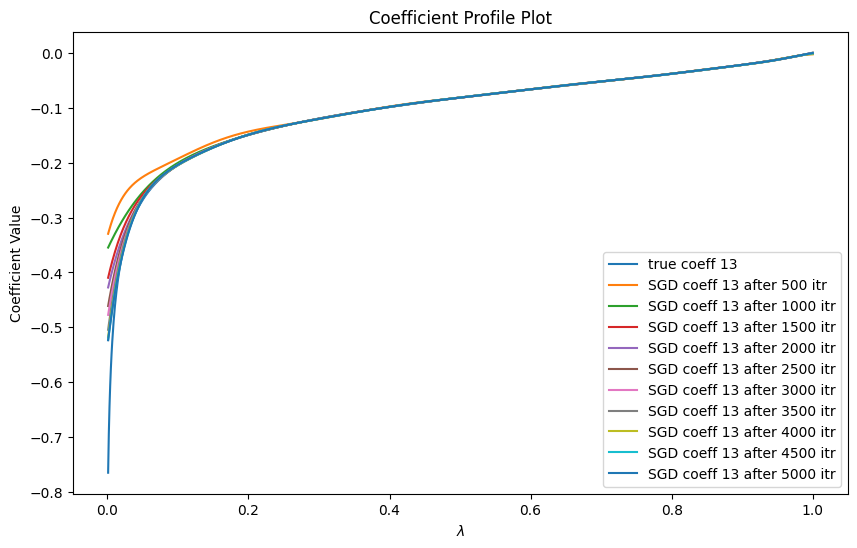

In [65]:
# Create a Matplotlib plot
plt.figure(figsize=(10, 6))
plt.plot(lambdas, true_thetas[:,coeff_index], label=f'true coeff {coeff_index}')

for i in range(0, len(thetas_SGD_history)):
    plt.plot(lambdas, thetas_SGD_history[i][:,coeff_index], label=f'SGD coeff {coeff_index} after {(i+1)*500} itr')


# Set plot labels and title
# plt.xscale('log')  # Log scale for the x-axis
plt.xlabel('$\\lambda$')
plt.ylabel('Coefficient Value')
plt.title('Coefficient Profile Plot')

# Add legend
plt.legend()

# Show the plot
plt.show()


### Coefficient profile plot when we use noisy gradient

In [69]:
# build the model
basis_dim = 13
epoch = 2000
alpha = 1

np.random.seed(8675309)
torch.manual_seed(8675309)
model = SGD.Basis_TF_SGD(input_dim, basis_dim, phi_lam, intercept=True).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
optimizer.zero_grad()
thetas_SGD_history = []
for t in range(epoch):
    # shrink learning rate
    lr = torch.min(torch.tensor([0.01, alpha/(t+1)]))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    SGD.train_SGD(SGD_data_loader, model, criterion, optimizer)
    if (t+1) % 200 == 0:
        thetas_SGD = []
        for lam in lambdas:
            thetas_SGD.append(model(lam).data.cpu().detach().numpy())
        thetas_SGD = np.array(thetas_SGD)
        thetas_SGD_history.append(thetas_SGD)

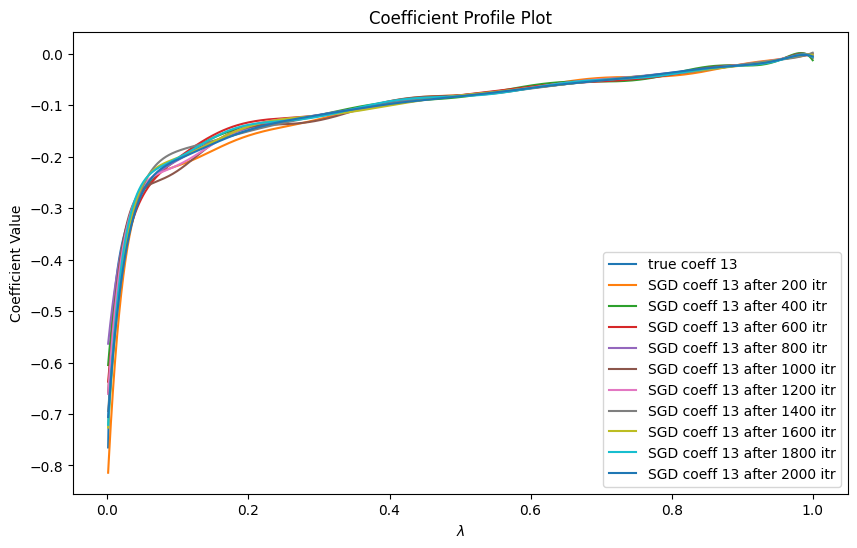

In [72]:
# Create a Matplotlib plot
plt.figure(figsize=(10, 6))
plt.plot(lambdas, true_thetas[:,coeff_index], label=f'true coeff {coeff_index}')

for i in range(0, len(thetas_SGD_history)):
    plt.plot(lambdas, thetas_SGD_history[i][:,coeff_index], label=f'SGD coeff {coeff_index} after {(i+1)*200} itr')


# Set plot labels and title
# plt.xscale('log')  # Log scale for the x-axis
plt.xlabel('$\\lambda$')
plt.ylabel('Coefficient Value')
plt.title('Coefficient Profile Plot')

# Add legend
plt.legend()

# Show the plot
plt.show()


# Compare Learning the Optimal Solution Path with Naive Grid Search

In [19]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [20]:
import time

## First, we run both methods for the exact gradient case.

### Learning the solution path:

Train the SGD model for our method using exact gradient and record the sup error along the solution path ($\epsilon$) achieved after executing some number of gradient calls (epochs).

We use the previously tuned learning rate $2^{-6}$.

In [38]:
# build the model
basis_dim = 13
epoch = 70000
lr = 0.5**6

np.random.seed(8675309)
torch.manual_seed(8675309)
model = SGD.Basis_TF_SGD(input_dim, basis_dim, phi_lam, intercept=True).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
optimizer.zero_grad()
sup_err_history = []
epochs = []

init_time = time.time()
total_time = time.time()
curr_time = time.time()
for t in range(epoch):
    SGD.train_SGD(GD_data_loader, model, criterion, optimizer)

    if (t+1) % 100 == 0:
        total_time += (time.time() - curr_time)

        epochs.append(t+1)
        print(f"---------approximate solution path for # epochs = {t+1} complete----------")
        sup_err = SGD.get_sup_error_SGD(lam_min, lam_max, true_losses,
                                    model, test_data_loader, criterion)
        sup_err_history.append(sup_err)
        print(f"epoch: {t+1}\t sup error: {sup_err}")
        curr_time = time.time()

sup_err_history = np.array(sup_err_history)

total_execution_time = total_time - init_time
print(f"Execution time: {total_execution_time} seconds")

---------approximate solution path for # epochs = 100 complete----------
epoch: 100	 sup error: 0.08277498185634619
---------approximate solution path for # epochs = 200 complete----------
epoch: 200	 sup error: 0.04136178642511373
---------approximate solution path for # epochs = 300 complete----------
epoch: 300	 sup error: 0.025080904364585925
---------approximate solution path for # epochs = 400 complete----------
epoch: 400	 sup error: 0.02227828651666646
---------approximate solution path for # epochs = 500 complete----------
epoch: 500	 sup error: 0.021631643176078845
---------approximate solution path for # epochs = 600 complete----------
epoch: 600	 sup error: 0.02098102122545247
---------approximate solution path for # epochs = 700 complete----------
epoch: 700	 sup error: 0.019976474344730426
---------approximate solution path for # epochs = 800 complete----------
epoch: 800	 sup error: 0.019221559166908313
---------approximate solution path for # epochs = 900 complete------

In [39]:
import csv

csv_file_path = '/content/drive/MyDrive/Experiments/SGD_results_exact.csv'

# Open the CSV file for writing
with open(csv_file_path, 'w', newline='') as csv_file:
    # Create a CSV writer
    csv_writer = csv.writer(csv_file)

    # Write the headers
    csv_writer.writerow(['num_itr', 'sup_err'])

    # Write the data from your lists
    for i in range(len(epochs)):
        csv_writer.writerow([epochs[i], sup_err_history[i]])

In [39]:
for i in range(len(sup_err_history)):
    sup_err_history[i] = np.min(sup_err_history[:i+1])

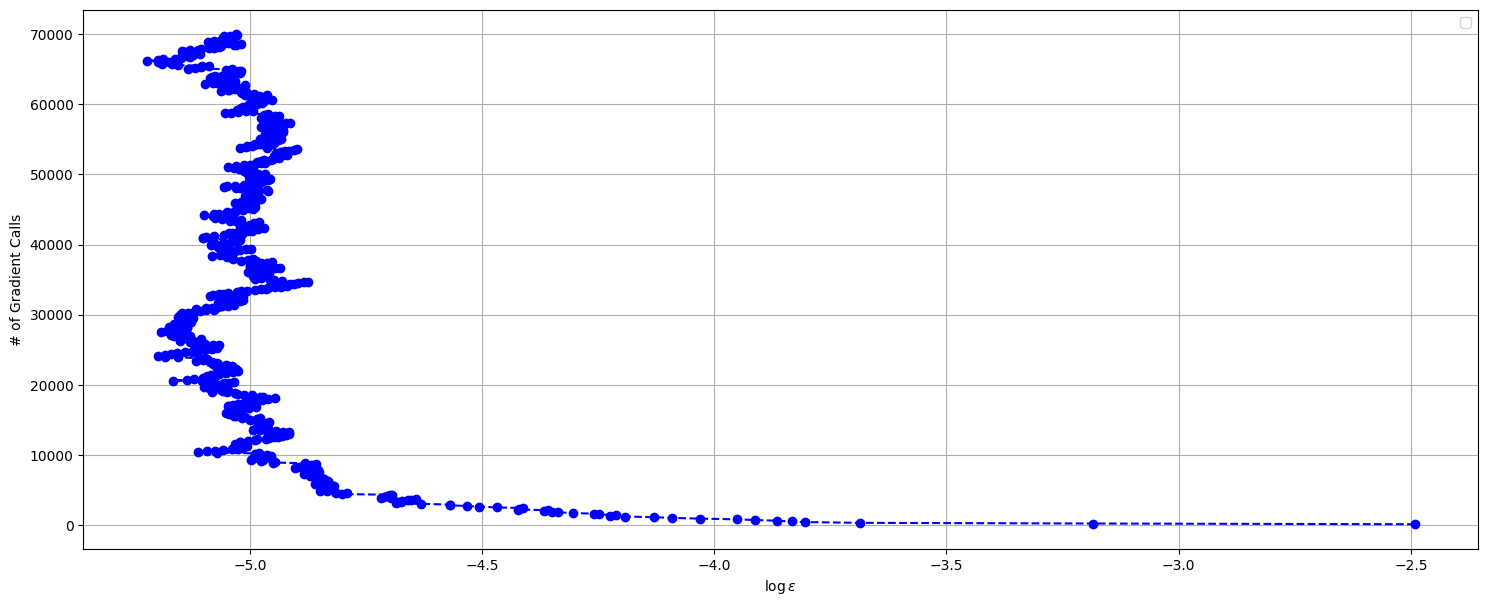

In [40]:
# plot result of learning the solution path
plt.figure(figsize=(18,7))
plt.plot(torch.log(torch.tensor(sup_err_history)), epochs, '--bo')
plt.ylabel('# of Gradient Calls')
plt.xlabel('$\\log\\epsilon$')
plt.legend()
plt.grid(True)

### Naive Grid Search:

In [41]:
lam_max = 1
lam_min = 0
lr = 0.5**4
max_epochs = 5000
# a list of solution accuracy delta wish to be achieved
delta_list = 0.5 ** torch.arange(6, 18)
print(delta_list)

tensor([1.5625e-02, 7.8125e-03, 3.9062e-03, 1.9531e-03, 9.7656e-04, 4.8828e-04,
        2.4414e-04, 1.2207e-04, 6.1035e-05, 3.0518e-05, 1.5259e-05, 7.6294e-06])


In [42]:
total_itr_list = []
sup_error_list = []
for delta in delta_list:
    # number of grids according to 1/sqrt(delta)
    num_grid = torch.round(1 / torch.sqrt(delta))

    start_time = time.time()
    models, total_itr = NGS.naive_grid_search(lam_min=lam_min, lam_max=lam_max,
                                    num_grid=num_grid, epochs=max_epochs, loss_fn=criterion,
                                    trainDataLoader=GD_data_loader,
                                    data_input_dim=input_dim,
                                    lr=lr, SGD=False, testDataLoader=test_data_loader,
                                    true_loss_list=true_losses, stopping_criterion=delta)
    end_time = time.time()
    execution_time = end_time - start_time

    total_itr_list.append(total_itr)

    sup_error = NGS.get_sup_error(lam_min, lam_max, true_losses, models, test_data_loader, criterion)
    sup_error_list.append(sup_error)

    print(f"grid #: {num_grid}\t total iteration #: {total_itr}\t sup error: {sup_error}\t Execution time: {execution_time} seconds")

total_itr_list = np.array(total_itr_list)
sup_error_list = np.array(sup_error_list)

grid #: 8.0	 total iteration #: 90	 sup error: 0.145929366350174	 Execution time: 8.481335401535034 seconds
grid #: 11.0	 total iteration #: 160	 sup error: 0.10539874434471136	 Execution time: 9.624683856964111 seconds
grid #: 16.0	 total iteration #: 290	 sup error: 0.07800197601318365	 Execution time: 9.923463582992554 seconds
grid #: 23.0	 total iteration #: 550	 sup error: 0.05872463434934621	 Execution time: 12.218369245529175 seconds
grid #: 32.0	 total iteration #: 1070	 sup error: 0.044664345681667376	 Execution time: 17.352994918823242 seconds
grid #: 45.0	 total iteration #: 2050	 sup error: 0.03408602625131612	 Execution time: 25.23066473007202 seconds
grid #: 64.0	 total iteration #: 3980	 sup error: 0.025242798030376483	 Execution time: 49.995598554611206 seconds
grid #: 91.0	 total iteration #: 7410	 sup error: 0.01809663325548177	 Execution time: 75.55576992034912 seconds
grid #: 128.0	 total iteration #: 12990	 sup error: 0.012975089251995135	 Execution time: 127.40325

In [43]:
# import csv

# csv_file_path = '/content/drive/MyDrive/Experiments/NGS_results_exact.csv'

# # Open the CSV file for writing
# with open(csv_file_path, 'w', newline='') as csv_file:
#     # Create a CSV writer
#     csv_writer = csv.writer(csv_file)

#     # Write the headers
#     csv_writer.writerow(['num_itr', 'sup_err'])

#     # Write the data from your lists
#     for i in range(len(total_itr_list)):
#         csv_writer.writerow([total_itr_list[i], sup_error_list[i]])

In [47]:
for i in range(len(sup_error_list)):
    sup_error_list[i] = np.min(sup_error_list[:i+1])

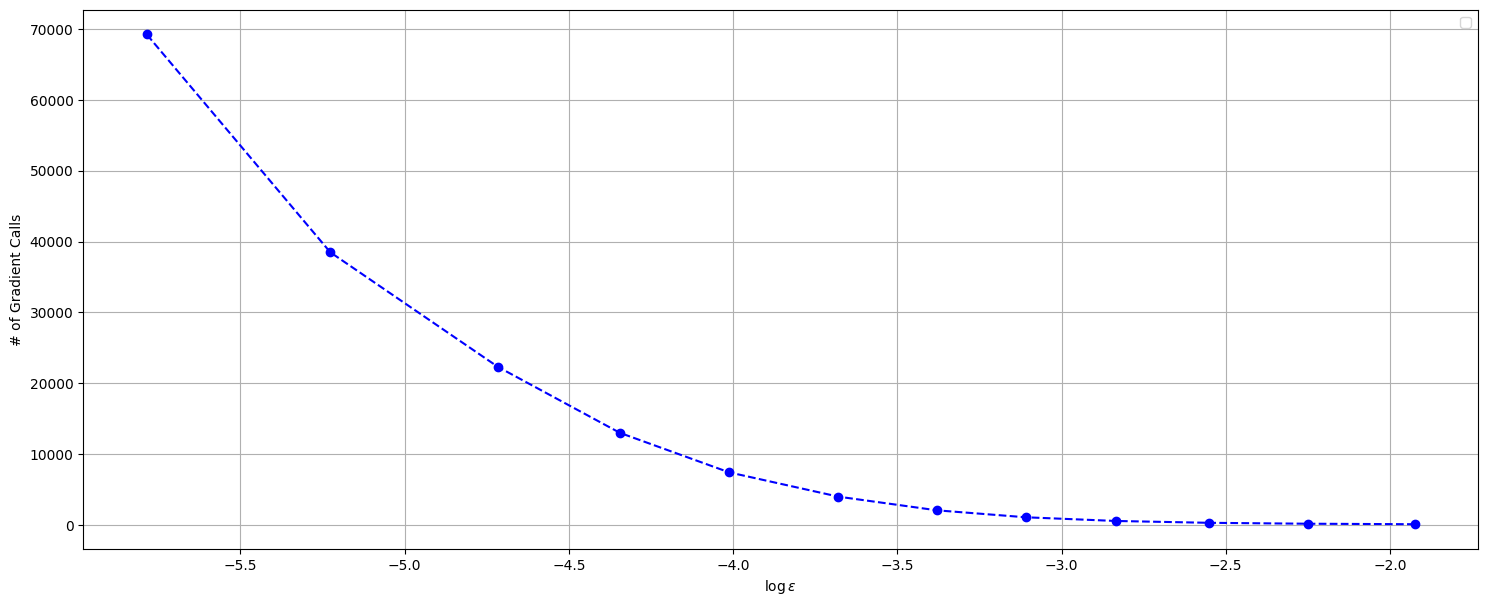

In [42]:
# plot result of learning the solution path
plt.figure(figsize=(18,7))
plt.plot(torch.log(torch.tensor(sup_error_list)), total_itr_list, '--bo')
plt.ylabel('# of Gradient Calls')
plt.xlabel('$\\log\\epsilon$')
plt.legend()
plt.grid(True)

## Plot Naive Grid Search vs Learning the Optimal Solution Path for the exact gradient case

In [32]:
csv_file_path = 'https://raw.githubusercontent.com/Cumberkid/Learning-the-Optimal-Solution-Path/main/NGS_results_exact.csv'
NGS_results_exact = pd.read_csv(csv_file_path)
num_itr_NGS = np.array(NGS_results_exact['num_itr'])
sup_err_NGS = np.array(NGS_results_exact['sup_err'])

In [33]:
csv_file_path = 'https://raw.githubusercontent.com/Cumberkid/Learning-the-Optimal-Solution-Path/main/SGD_results_exact.csv'
SGD_results_exact = pd.read_csv(csv_file_path)
num_itr_SGD = np.array(SGD_results_exact['num_itr'])
sup_err_SGD = np.array(SGD_results_exact['sup_err'])

In [31]:
for i in range(len(sup_err_SGD)):
    sup_err_SGD[i] = np.min(sup_err_SGD[:i+1])

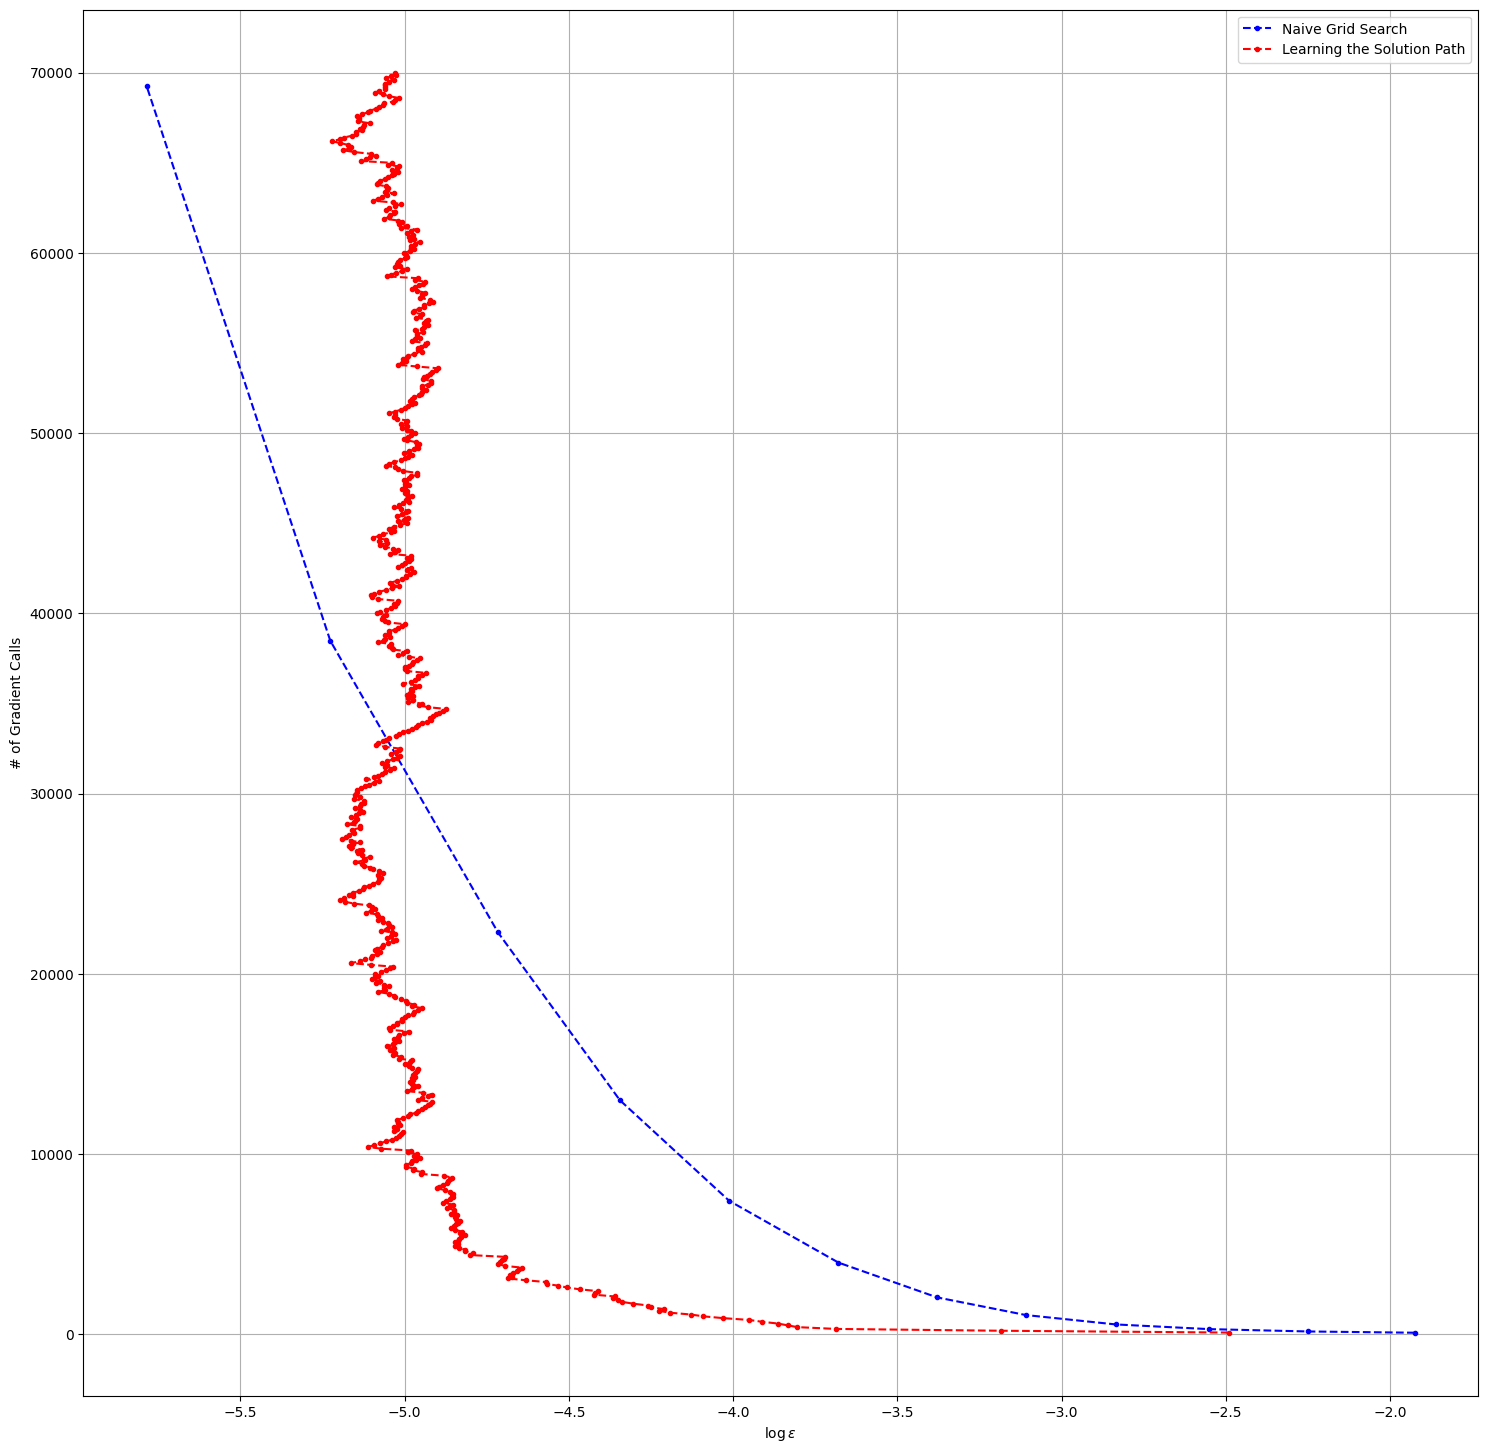

In [38]:
# plot result of learning the solution path
plt.figure(figsize=(18,18))
plt.plot(np.log(sup_err_NGS), num_itr_NGS, '--b.', label = "Naive Grid Search")
plt.plot(np.log(sup_err_SGD), num_itr_SGD, '--r.', label = "Learning the Solution Path")
plt.ylabel('# of Gradient Calls')
plt.xlabel('$\\log\\epsilon$')
plt.legend()
plt.grid(True)

## Then, we run both methods for the noisy gradient case.

### Learning the solution path:

Train the SGD model for our method using noisy gradient (mini-batch SGD) and record the sup error along the solution path ($\epsilon$) achieved after executing some number of gradient calls (epochs).

We use the previously tuned shrinking rate $\alpha = 1$.

In [36]:
# build the model
basis_dim = 13
epoch = 70000
alpha = 1
np.random.seed(8675309)
torch.manual_seed(8675309)

model = SGD.Basis_TF_SGD(input_dim, basis_dim, phi_lam, intercept=True).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
optimizer.zero_grad()
sup_err_history = []
epochs = []

init_time = time.time()
total_time = time.time()
curr_time = time.time()
for t in range(epoch):
    # shrink learning rate
    lr = torch.min(torch.tensor([0.01, alpha/(t+1)]))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    SGD.train_SGD(SGD_data_loader, model, criterion, optimizer)

    if (t+1) % 100 == 0:
        total_time += (time.time() - curr_time)

        epochs.append(t+1)
        print(f"---------approximate solution path for # epochs = {t+1} complete----------")
        sup_err = SGD.get_sup_error_SGD(lam_min, lam_max, true_losses,
                                    model, test_data_loader, criterion)
        sup_err_history.append(sup_err)
        print(f"epoch: {t+1}\t sup error: {sup_err}")
        curr_time = time.time()

sup_err_history = np.array(sup_err_history)

total_execution_time = total_time - init_time
print(f"Execution time: {total_execution_time} seconds")

---------approximate solution path for # epochs = 100 complete----------
epoch: 100	 sup error: 0.03427514433860784
---------approximate solution path for # epochs = 200 complete----------
epoch: 200	 sup error: 0.013044014573097278
---------approximate solution path for # epochs = 300 complete----------
epoch: 300	 sup error: 0.01165688782930379
---------approximate solution path for # epochs = 400 complete----------
epoch: 400	 sup error: 0.008240245282650042
---------approximate solution path for # epochs = 500 complete----------
epoch: 500	 sup error: 0.012601755559444476
---------approximate solution path for # epochs = 600 complete----------
epoch: 600	 sup error: 0.006793558597564746
---------approximate solution path for # epochs = 700 complete----------
epoch: 700	 sup error: 0.007156781852245379
---------approximate solution path for # epochs = 800 complete----------
epoch: 800	 sup error: 0.007143497467041064
---------approximate solution path for # epochs = 900 complete----

In [37]:
import csv

csv_file_path = '/content/drive/MyDrive/Experiments/SGD_results_noisy.csv'

# Open the CSV file for writing
with open(csv_file_path, 'w', newline='') as csv_file:
    # Create a CSV writer
    csv_writer = csv.writer(csv_file)

    # Write the headers
    csv_writer.writerow(['num_itr', 'sup_err'])

    # Write the data from your lists
    for i in range(len(epochs)):
        csv_writer.writerow([epochs[i], sup_err_history[i]])

In [ ]:
for i in range(len(sup_err_history)):
    sup_err_history[i] = np.min(sup_err_history[:i+1])
# print(model_SGD.linear.weight)

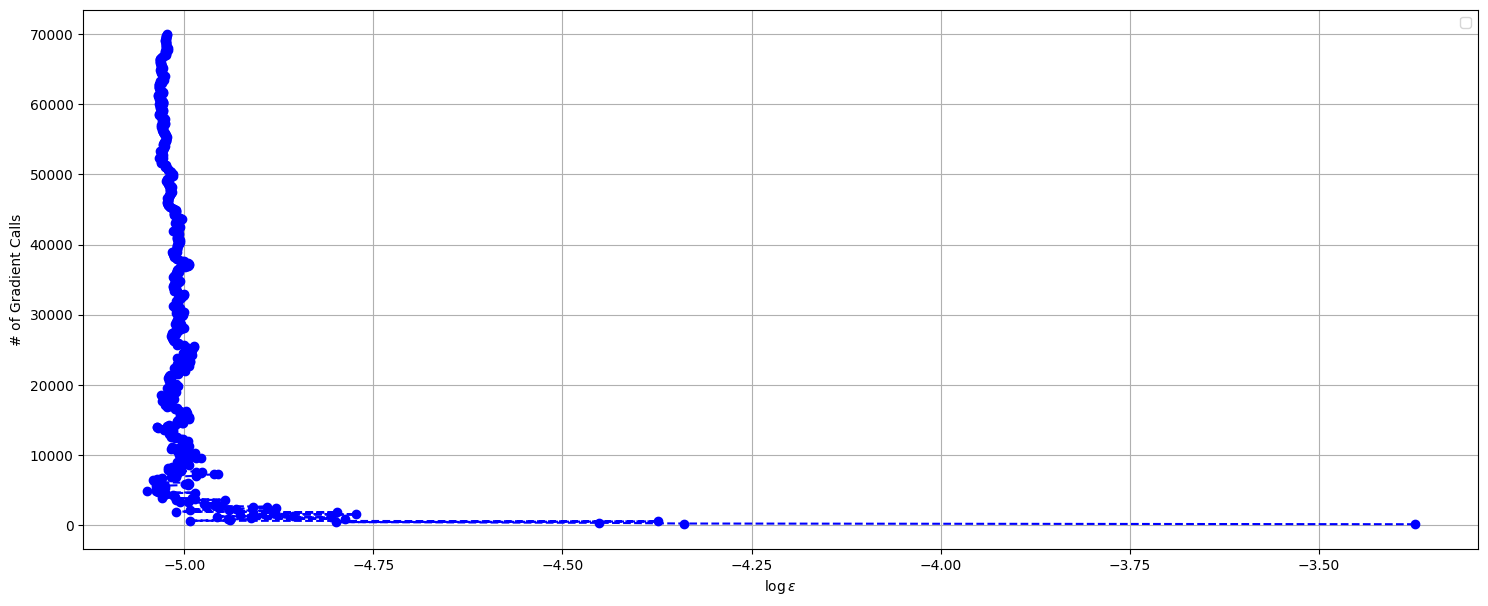

In [38]:
# plot result of learning the solution path
plt.figure(figsize=(18,7))
plt.plot(torch.log(torch.tensor(sup_err_history)), epochs, '--bo')
plt.ylabel('# of Gradient Calls')
plt.xlabel('$\\log\\epsilon$')
plt.legend()
plt.grid(True)

### Naive Grid Search:

In [34]:
lam_max = 1
lam_min = 0
alpha = 2
max_epochs = 5000
# a list of solution accuracy delta wish to be achieved
delta_list = 0.5 ** torch.arange(6, 18)
print(delta_list)

tensor([1.5625e-02, 7.8125e-03, 3.9062e-03, 1.9531e-03, 9.7656e-04, 4.8828e-04,
        2.4414e-04, 1.2207e-04, 6.1035e-05, 3.0518e-05, 1.5259e-05, 7.6294e-06])


In [35]:
total_itr_list = []
sup_error_list = []
np.random.seed(8675309)
torch.manual_seed(8675309)
for delta in delta_list:
    # number of grids according to 1/sqrt(delta)
    num_grid = torch.round(1 / torch.sqrt(delta))

    start_time = time.time()
    models, total_itr = NGS.naive_grid_search(lam_min=lam_min, lam_max=lam_max,
                                    num_grid=num_grid, epochs=max_epochs, loss_fn=criterion,
                                    trainDataLoader=SGD_data_loader,
                                    data_input_dim=input_dim,
                                    alpha=alpha, SGD=True, testDataLoader=test_data_loader,
                                    true_loss_list=true_losses, stopping_criterion=delta)
    end_time = time.time()
    execution_time = end_time - start_time

    total_itr_list.append(total_itr)
    sup_error = NGS.get_sup_error(lam_min, lam_max, true_losses, models, test_data_loader, criterion)
    sup_error_list.append(sup_error)

    print(f"grid #: {num_grid}\t total iteration #: {total_itr}\t sup error: {sup_error}\t Execution time: {execution_time} seconds")

total_itr_list = np.array(total_itr_list)
sup_error_list = np.array(sup_error_list)

grid #: 8.0	 total iteration #: 80	 sup error: 0.0940170586109162	 Execution time: 12.46614122390747 seconds
grid #: 11.0	 total iteration #: 110	 sup error: 0.07825493812561041	 Execution time: 17.843955755233765 seconds
grid #: 16.0	 total iteration #: 180	 sup error: 0.0595888420939446	 Execution time: 28.446918487548828 seconds
grid #: 23.0	 total iteration #: 310	 sup error: 0.04952919483184819	 Execution time: 49.60980248451233 seconds
grid #: 32.0	 total iteration #: 700	 sup error: 0.03975839912891393	 Execution time: 110.49579405784607 seconds
grid #: 45.0	 total iteration #: 1270	 sup error: 0.030136473476886798	 Execution time: 200.2077956199646 seconds
grid #: 64.0	 total iteration #: 2710	 sup error: 0.022491000592708636	 Execution time: 425.9677450656891 seconds
grid #: 91.0	 total iteration #: 5120	 sup error: 0.016932755708694507	 Execution time: 809.8887429237366 seconds
grid #: 128.0	 total iteration #: 9520	 sup error: 0.011961139738559771	 Execution time: 1518.83471

In [36]:
import csv

csv_file_path = '/content/drive/MyDrive/Experiments/NGS_results_noisy.csv'

# Open the CSV file for writing
with open(csv_file_path, 'w', newline='') as csv_file:
    # Create a CSV writer
    csv_writer = csv.writer(csv_file)

    # Write the headers
    csv_writer.writerow(['num_itr', 'sup_err'])

    # Write the data from your lists
    for i in range(len(total_itr_list)):
        csv_writer.writerow([total_itr_list[i], sup_error_list[i]])

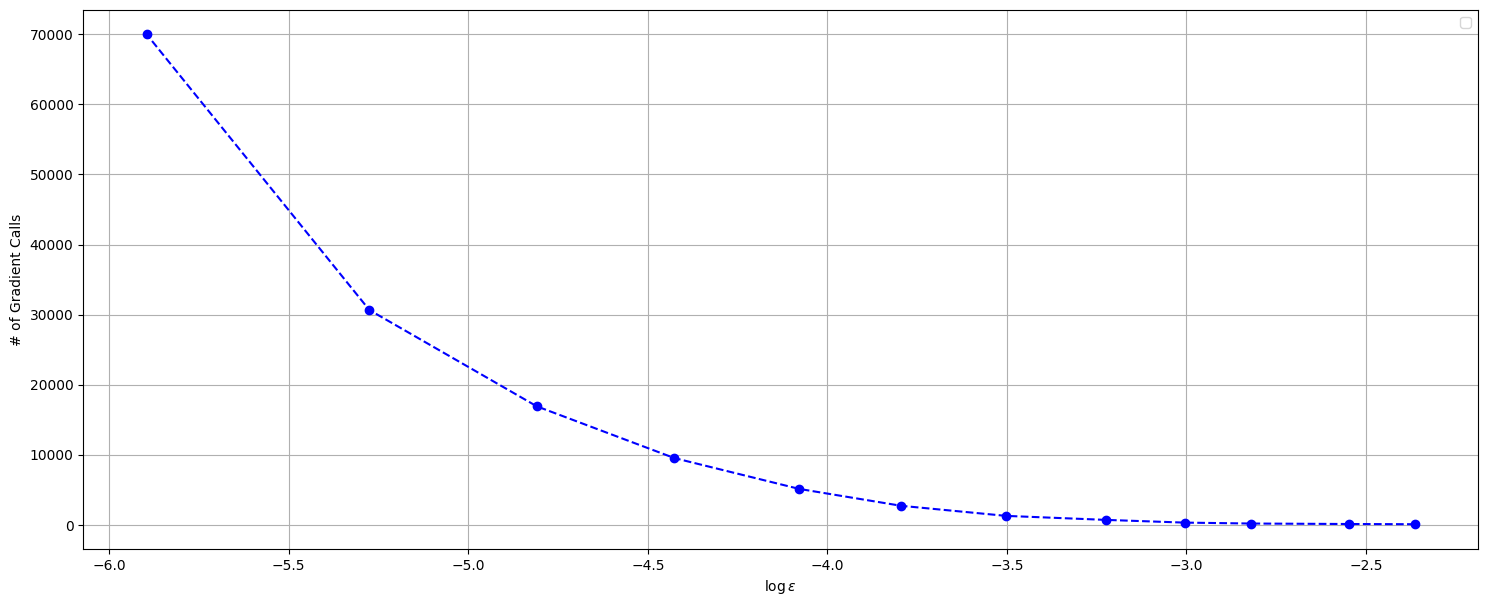

In [37]:
# plot result of learning the solution path
plt.figure(figsize=(18,7))
plt.plot(torch.log(torch.tensor(sup_error_list)), total_itr_list, '--bo', )
plt.ylabel('# of Gradient Calls')
plt.xlabel('$\\log\\epsilon$')
plt.legend()
plt.grid(True)

## Plot Naive Grid Search vs Learning the Optimal Solution Path for the noisy gradient case

In [39]:
csv_file_path = 'https://raw.githubusercontent.com/Cumberkid/Learning-the-Optimal-Solution-Path/main/NGS_results_noisy.csv'
NGS_results_exact = pd.read_csv(csv_file_path)
num_itr_NGS = np.array(NGS_results_exact['num_itr'])
sup_err_NGS = np.array(NGS_results_exact['sup_err'])

In [40]:
csv_file_path = 'https://raw.githubusercontent.com/Cumberkid/Learning-the-Optimal-Solution-Path/main/SGD_results_noisy.csv'
SGD_results_exact = pd.read_csv(csv_file_path)
num_itr_SGD = np.array(SGD_results_exact['num_itr'])
sup_err_SGD = np.array(SGD_results_exact['sup_err'])

In [12]:
for i in range(len(sup_err_SGD)):
    sup_err_SGD[i] = np.min(sup_err_SGD[:i+1])

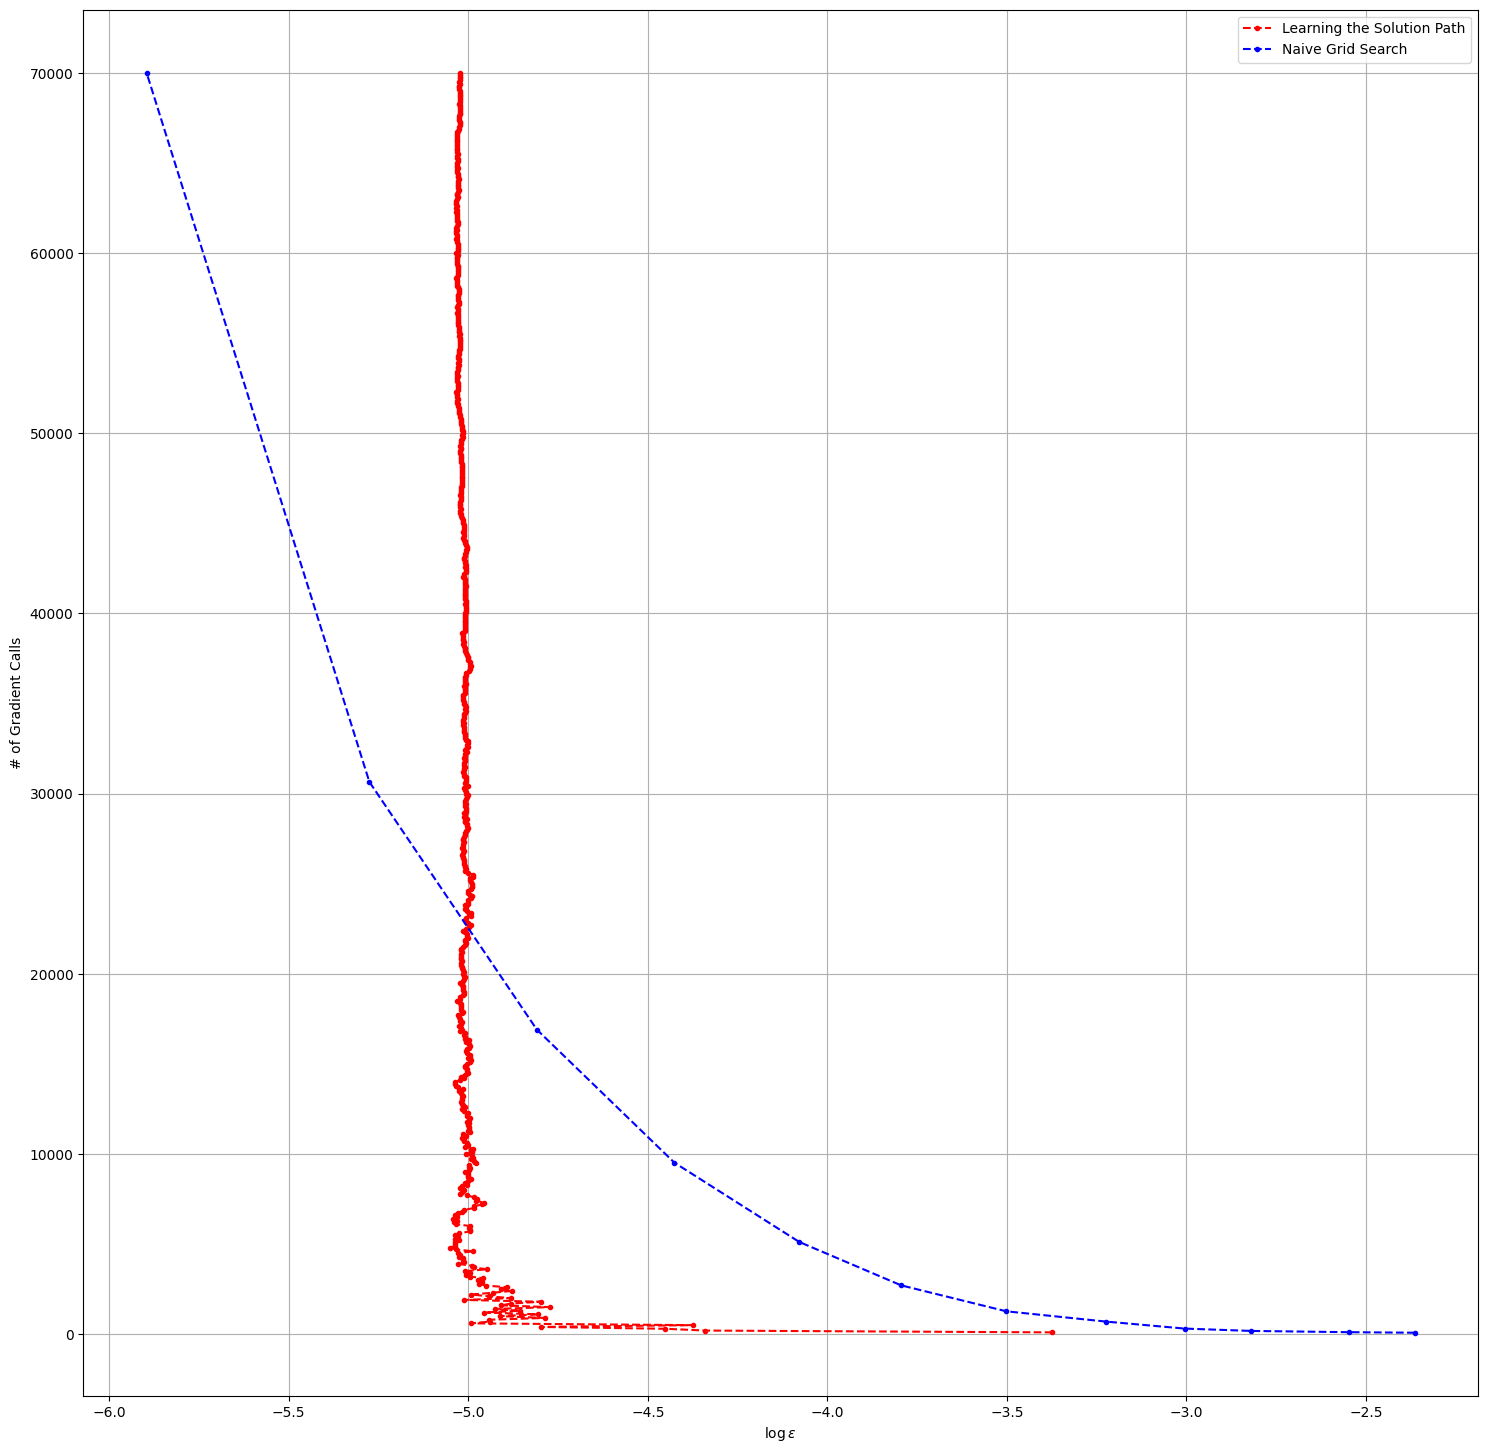

In [42]:
# plot result of learning the solution path
plt.figure(figsize=(18,18))
plt.plot(torch.log(torch.tensor(sup_err_SGD)), num_itr_SGD, '--r.', label = "Learning the Solution Path")
plt.plot(torch.log(torch.tensor(sup_err_NGS)), num_itr_NGS, '--b.', label = "Naive Grid Search")
plt.ylabel('# of Gradient Calls')
plt.xlabel('$\\log\\epsilon$')
plt.legend()
plt.grid(True)

#Discarded

##Naive Grid Search
To gauge the performance of our model, we first set up a benchmark with Naive Grid Search.

This method discretize the path over $\lambda \in [0,1]$ into a number of grids and trains a linear model on each grid.

In [ ]:
# running gradient descent with fixed learning rate on a single grid point, i.e. for one specified lambda
def GD_on_a_grid(lam, epochs, weight, trainDataLoader, data_input_dim,
                 lr=1e-3, alpha=1, SGD=False, testDataLoader=None,
                 true_loss_list=None, fine_delta_lam=None, stopping_criterion=None):
    criterion=torch.nn.BCELoss()
    model = my_logit.Logistic_Regression(data_input_dim, 1, lam, weight).to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    optimizer.zero_grad()

    if true_loss_list is not None:
        # exact solution
        i = torch.round((1-lam) / fine_delta_lam).int()
        if i >= len(true_loss_list):
            i -= 1
            i.int()
        exact_soln = true_loss_list[i]
        # print(i)

    early_stop = False
    itr = 0
    for t in range(epochs):
        if SGD:
            # shrink learning rate
            lr = torch.min(torch.tensor([0.1, alpha/(t+1)]))
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr
        my_logit.train(trainDataLoader, model, criterion, optimizer, trace_frequency=5)
        if true_loss_list is not None:
            if (t+1) % 10 == 0:
                # do an accuracy check
                approx_soln = my_logit.test(testDataLoader, model, criterion, lam)
                error = approx_soln - exact_soln
                # stopping criterion
                if error <= stopping_criterion:
                    itr += (t+1)
                    early_stop = True
                    break  # Early stop

    if not early_stop:
        itr += epochs

    return model, itr

Naive Grid Search starts from $\lambda = 1$ and decreases $\lambda$ by $\Delta\lambda = \frac{\lambda_\text{max} - \lambda_\text{min}}{\text{# of grid}}$. The model trained on each grid point $(\lambda - \Delta\lambda)$ initializes weight with the linear weight of the model trained on the previous grid point $\lambda$.

In [ ]:
# do the whole naive grid search over a list of uniformly spaced lambda's
# from lam_min to lam_max
# returns a list of trained models
def naive_grid_search(lam_min, lam_max, num_grid, epochs, trainDataLoader,
                      data_input_dim, lr=0.5**4, alpha=4, SGD=False,
                      testDataLoader=None, true_loss_list=None, stopping_criterion=None):
    delta_lam = (lam_max - lam_min)/num_grid
    fine_delta_lam = None
    if true_loss_list is not None:
        fine_delta_lam = (lam_max - lam_min)/len(true_loss_list)
    model_list = []
    total_itr = 0
    # create a list of lambda's
    lambdas = torch.arange(lam_max, lam_min, (-1)*delta_lam).to(device)

    # first weight is initialized at 0
    weight = torch.zeros(data_input_dim)

    for lam in lambdas:
        # print(f"Running model on lambda = {lam}")
        model, itr = GD_on_a_grid(lam, epochs, weight,
                                  trainDataLoader=trainDataLoader,
                                  data_input_dim=data_input_dim,
                                  lr=lr, alpha=alpha,
                                  SGD=SGD, testDataLoader=testDataLoader,
                                  true_loss_list=true_loss_list,
                                  fine_delta_lam=fine_delta_lam,
                                  stopping_criterion=stopping_criterion)
        weight = model.linear.weight
        model_list.append(model)
        total_itr += itr
        # print(total_itr)

    return model_list, total_itr

Helper function that takes in a list of coarse grid models and returns the sup error over $\lambda\in[0,1]$ compared to the exact solutions.

In [ ]:
def get_losses(coarse_model_list, data_loader, criterion):
  losses = []
  for model in coarse_model_list:
      losses.append(my_logit.test(data_loader, model, criterion, model.reg_param))

  return losses

In [ ]:
def get_sup_error(lam_min, lam_max, true_loss_list, coarse_model_list, data_loader, criterion):
    fine_delta_lam = torch.tensor((lam_max - lam_min)/len(true_loss_list))
    delta_lam = torch.tensor((lam_max - lam_min)/len(coarse_model_list))
    # check sup error
    sup_error = 0
    for i in range(len(true_loss_list)):
        true_loss = true_loss_list[i]
        coarse_grid = torch.round(i * fine_delta_lam / delta_lam).int()
        if coarse_grid >= len(coarse_model_list):
            coarse_grid -= 1
            coarse_grid.int()
        # print(i, coarse_grid)
        temp = 1 - i * fine_delta_lam
        # approximate solution uses the linear weight of coarse grid model to test for regression parameter of the fine grid
        approx_loss = my_logit.test(data_loader, coarse_model_list[coarse_grid], criterion, temp)
        sup_error = torch.max(torch.tensor([sup_error, approx_loss - true_loss]))
        # print(i, coarse_grid, sup_error)
    return sup_error.item()

In [ ]:
true_loss_list = torch.zeros(70)

In [ ]:
models, num_itr = naive_grid_search(lam_min=0, lam_max=1, num_grid=5, epochs=500,
                                    trainDataLoader=tune_GD_data_loader,
                                    data_input_dim=input_dim,
                                    lr=0.5**4, SGD=False,
                                    testDataLoader=tune_test_data_loader,
                                    true_loss_list=true_loss_list,
                                    stopping_criterion=0.1)

In [ ]:
num_itr

2010

In [ ]:
for model in models:
    print(model.linear.weight.data.cpu().detach().numpy()[0])
    # print(my_logit.test(tune_test_data_loader, model, criterion, model.reg_param))

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]
[-0.04793325 -0.03711667 -0.04909439 -0.04270919 -0.02193255 -0.04546908
 -0.0435608  -0.05390455 -0.02183017 -0.00021597 -0.03355921  0.00564824
 -0.0353306  -0.03083319  0.01586902 -0.01721219 -0.0044905  -0.02397951
  0.0152274  -0.00013568 -0.05467103 -0.04125571 -0.05641661 -0.04802518
 -0.03637676 -0.05609273 -0.04757181 -0.06489053 -0.04073238 -0.04014045]
[-0.08545861 -0.07462558 -0.08704397 -0.07533451 -0.03311095 -0.07197149
 -0.07045873 -0.09258562 -0.02943309  0.0087167  -0.05914386  0.00972365
 -0.06183466 -0.05354279  0.02831364 -0.01857452  0.00539135 -0.03903972
  0.04035656  0.00933711 -0.09646229 -0.08048616 -0.09956673 -0.08347255
 -0.06363086 -0.09241115 -0.07624716 -0.11407547 -0.06356283 -0.06573535]
[-0.12583384 -0.12631583 -0.12782133 -0.10992517 -0.04113182 -0.09565082
 -0.09594136 -0.1331998  -0.03235774  0.02269203 -0.08952836  0.01245007
 -0.0935027  -0.07877338  0.0

In [ ]:
sup_error = get_sup_error(lam_min=0, lam_max=1, true_loss_list=true_loss_list,
                          coarse_model_list=models, data_loader=tune_test_data_loader,
                          criterion=criterion)

In [ ]:
sup_error

0.22968055307865143

Since we are doing optimization, there is no need to do a train-test split. Instead, we will train and test on the whole dataset.

In [ ]:
# # Split dataset
# # test : val : train = 2 : 1 : 7
# # Not using validation set for now
# from torch.utils.data import random_split

# test_size = torch.tensor(len(reg_data) * 0.3).int()
# #val_size = torch.tensor(len(reg_data) * 0.1).int()
# train_size = len(reg_data) - test_size
# train_set, test_set = random_split(reg_data, [train_size, test_size])

# train_data_loader = DataLoader(train_set, batch_size=batch_size, shuffle=False, )
# test_data_loader = DataLoader(test_set, batch_size=len(test_set), shuffle=False, )

# # print(next(iter(test_data_loader)))

In [ ]:
lr_list = 0.5 ** torch.arange(2, 13)
num_epochs = torch.tensor([100, 500, 1000])
print(lr_list)
print(num_epochs)
max_epoch = torch.max(num_epochs)

tensor([2.5000e-01, 1.2500e-01, 6.2500e-02, 3.1250e-02, 1.5625e-02, 7.8125e-03,
        3.9062e-03, 1.9531e-03, 9.7656e-04, 4.8828e-04, 2.4414e-04])
tensor([ 100,  500, 1000])


In [ ]:
# tune learning rate on the first 100 datapoints
data = Regression_Data(X[:100, :], y[:100])
# full gradient descent uses all data points
GD_data_loader = DataLoader(data, batch_size=len(data), shuffle=True, )
# stochastic gradient descent uses mini-batch
SGD_data_loader = DataLoader(data, batch_size=5, shuffle=True, )
# test data
test_data_loader = DataLoader(data, batch_size=len(reg_data), shuffle=False, )

##Selecting the Best Number of Grid Points to Use for Tuning the Learning Rate
We take
\begin{align*}
\sup_{\lambda} \{h(\hat{\theta}(\lambda), \lambda) - h(\theta^*(\lambda), \lambda)\}
\end{align*}
over a list of uniformly spaced $\lambda$'s. To simulate $\theta^*(\lambda)$, we onstruct a very fine grid of $\lambda$ and run SGD over this grid.

In [ ]:
tune_data = Regression_Data(X[:100, :], y[:100])
tune_data_loader = DataLoader(tune_data, batch_size=len(tune_data), shuffle=True, )

In [ ]:
lam_max = torch.tensor(1).to(device)
lam_min = torch.tensor(0).to(device)
fine_num_grid = 2**10
epochs = 5000
fine_delta_lam = (lam_max - lam_min)/fine_num_grid

In [ ]:
# a fine grid to simulate the exact solution path $\theta^*(\lambda)$
tune_fine_model_list = naive_grid_search(lam_min, lam_max, num_grid, epochs, tune_data_loader, 1e-3)
tune_exact_soln_list = []
for model in tune_fine_model_list:
    tune_exact_soln_list.append(test(tune_data_loader, model, criterion, model.reg_param))
print("---------tune exact solution path complete----------")
print(f"tune_exact_soln_list = {tune_exact_soln_list}")

---------tune exact solution path complete----------
tune_exact_soln_list = [5.022323179559862e-08, 0.03418022394180298, 0.06836150586605072, 0.1904347985982895, 0.13672712445259094, 0.17091143131256104, 0.205097958445549, 0.4443650245666504, 0.5078492760658264, 0.3076607882976532, 0.6348252296447754, 0.3760388493537903, 0.750082790851593, 0.4444253742694855, 0.47861701250076294, 0.9522795081138611, 0.547005832195282, 0.14956888556480408, 0.6153932213783264, 0.6125032901763916, 0.6837976574897766, 0.20531418919563293, 0.19361737370491028, 0.24734807014465332, 0.28155624866485596, 0.3665352165699005, 1.2445142269134521, 0.6595515012741089, 0.13712765276432037, 0.19867625832557678, 1.1723679304122925, 1.120642066001892, 1.2818101644515991, 0.2261485755443573, 1.1626673936843872, 0.9576839208602905, 0.6334936022758484, 0.651107668876648, 1.2995201349258423, 1.33372962474823, 0.35236018896102905, 0.5213660597801208, 1.0262432098388672, 0.37884265184402466, 0.30175331234931946, 0.2207299023

In [ ]:
# number of grid points in the coarse grids, created as subsets of the fine grid
num_grid_list = 2 ** torch.arange(2, 10)
print(f"num_grid_list = {num_grid_list}")

num_grid_list = tensor([  4,   8,  16,  32,  64, 128, 256, 512])


In [ ]:
error_list = []

for num in torch.arange(2, 10):
    sup_error = 0
    skip = 2 ** (10 - num)

    for i in range(len(tune_exact_soln_list)):
        exact_soln = tune_exact_soln_list[i]
        temp = 1 - i * fine_delta_lam

        coarse_grid = (torch.round(i/ skip) * skip).int()
        if coarse_grid >= len(tune_exact_soln_list):
            coarse_grid -= skip
            coarse_grid.int()
        # print(i, coarse_grid)

        # approximate solution uses the linear weight of coarse grid model to test for regression parameter of the fine grid
        approx_soln = test(tune_data_loader, tune_fine_model_list[coarse_grid], criterion, temp)
        sup_error = torch.max(torch.tensor([sup_error, approx_soln - exact_soln]))
        # print(sup_error)

    print(f"# grid: {2**num}\t sup error: {sup_error}")
    error_list.append(sup_error)

print(f"error_list = {error_list}")

# grid: 4	 sup error: 10.799158096313477
# grid: 8	 sup error: 6.149971008300781
# grid: 16	 sup error: 4.406752109527588
# grid: 32	 sup error: 3.3502249717712402
# grid: 64	 sup error: 3.4311978816986084
# grid: 128	 sup error: 3.417623519897461
# grid: 256	 sup error: 3.481377363204956
# grid: 512	 sup error: 3.481377363204956
error_list = [tensor(10.7992), tensor(6.1500), tensor(4.4068), tensor(3.3502), tensor(3.4312), tensor(3.4176), tensor(3.4814), tensor(3.4814)]


In [ ]:
tune_error_list = []
num_grid_list = []
for num in torch.arange(2, 10):
    # number of grid points in the coarse grid
    num_grid = 2**num
    num_grid_list.append(num_grid)
    delta_lam = (lam_max - lam_min)/num_grid

    # build the coarse grid by selecting from the fine grid
    skip = (fine_num_grid/num_grid).int()
    coarse_model_list = tune_fine_model_list[0::skip]

    sup_error = get_sup_error(tune_exact_soln_list, fine_delta_lam, coarse_model_list, delta_lam, tune_data_loader, criterion)
    print(f"# grid: {num_grid}\t sup error: {sup_error}")
    error_list.append(sup_error)

print(f"tune_error_list = {tune_error_list}")

Selecting the Number of Grids for Naive Grid Search:
Plot $\sup_{\lambda} \{h(\hat{\theta}(\lambda), \lambda) - h(\theta^*(\lambda), \lambda)\}$ against $\Delta\lambda$. A grid number of $2^5 = 32$

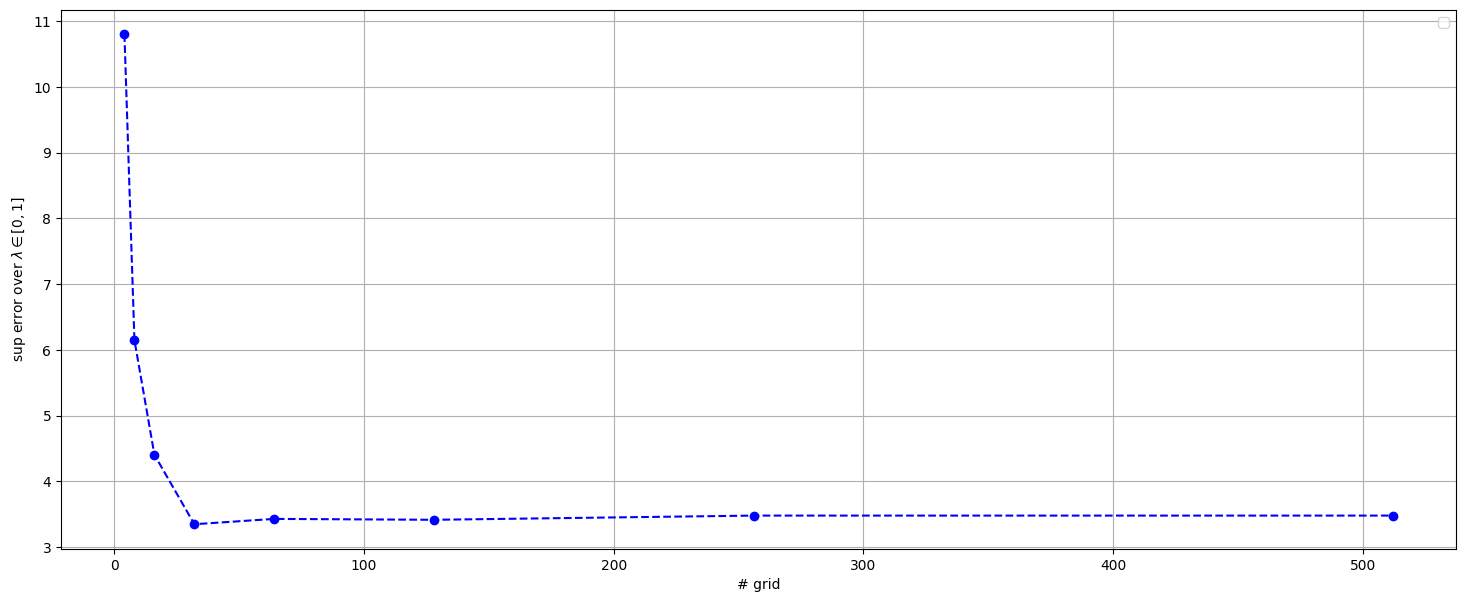

In [ ]:
# plot result of our method:
plt.figure(figsize=(18,7))
plt.plot(num_grid_list, error_list, '--bo')
plt.xlabel('# grid')
plt.ylabel(f"sup error over $\\lambda\\in [{lam_min}, {lam_max}]$")
plt.legend()
plt.grid(True)

## Tuning the Learning Rate

Use the first 100 datapoints to select the best constant learning rate for learning the solution path when # basis = 3.

Make several plots of sup error along the solution path against learning rate using 1000 epochs.

In [ ]:
errs = []
for lr in lr_list:
    # train a model
    model = Logistic_Regression(data.input_dim, 1, 0.01, torch.zeros(data.input_dim))
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    optimizer.zero_grad()
    temp = []
    for t in range(max_epoch):
        train(GD_data_loader, model, criterion, optimizer, trace_frequency=5)
        for epoch in num_epochs:
            if t == epoch - 1:
                loss = test(GD_data_loader, model, criterion, model.reg_param)
                temp.append(loss)
    errs.append(temp)

errs = np.array(errs).T
print(errs)

[[ 2.01097894  2.99287939  2.98511267  3.9691689   4.9551034   4.95267773
   6.93122005  9.90048504  7.92014647 12.87004757 26.73001099]
 [ 2.01851606  2.01717019  2.01284623  2.0054462   2.98734736  3.97083163
   3.96624422  4.95335102  4.95150757  8.91065311  5.94021463]
 [ 2.01875758  2.01852465  2.01716113  2.01288867  2.00538826  2.98739743
   3.97081733  3.96626663  4.95322227  5.94158411  4.95061636]]


<ipython-input-62-e031e0da55e3>:5: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "--bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(torch.log(lr_list), errs[i], '--bo', color = colors[i], label = f"# Epochs = {num_epochs[i].item()}")


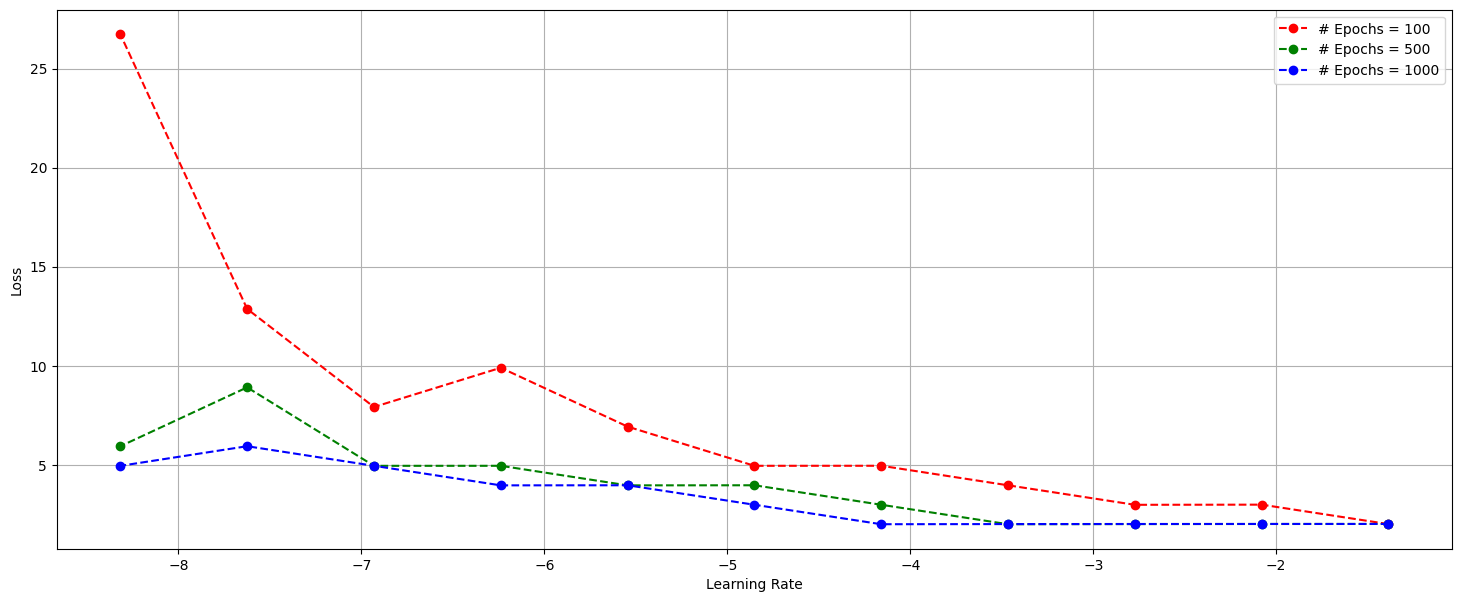

In [ ]:
# plot result of our method:
plt.figure(figsize=(18,7))
colors = ['r', 'g', 'b']
for i in range(len(num_epochs)):
    plt.plot(torch.log(lr_list), errs[i], '--bo', color = colors[i], label = f"# Epochs = {num_epochs[i].item()}")
plt.xlabel('Learning Rate')
plt.ylabel(f"Loss")
plt.legend()
plt.grid(True)

In [ ]:
# Compute the approximate solution path
def solution_path_SGD(basis_dim, epochs):
    # build the model
    weight = torch.normal(0, 1, (1, reg_data.input_dim*basis_dim))
    model = Logistic_Regression(reg_data.input_dim*basis_dim, 1, 0, weight).to(device)# reg_param = 0 here is only a space holder
    optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
    optimizer.zero_grad()

    for t in range(epochs):
        train_SGD(GD_data_loader, model, criterion, optimizer, basis_dim, trace_frequency=5)

    #print(model.norm_beta())
    print("Done!")

    return model

In [ ]:
basis_dim = torch.tensor(3).to(device)
max_epoch = torch.tensor(100).to(device)
model_SGD = solution_path_SGD(basis_dim, max_epoch)
print(f"---------approximate solution path for basis dimension = {basis_dim} complete----------")
weight = torch.clone(model_SGD.linear.weight).detach()

Done!
---------approximate solution path for basis dimension = 3 complete----------


In [ ]:
print(failed)
print(lams)
print(errs)

[0.9750000238418579, 0.9624999761581421, 0.887499988079071, 0.824999988079071, 0.7875000238418579, 0.037499986588954926, 0.012499985285103321]
[1.0, 0.9990234375, 0.998046875, 0.9970703125, 0.99609375, 0.9951171875, 0.994140625, 0.9931640625, 0.9921875, 0.9912109375, 0.990234375, 0.9892578125, 0.98828125, 0.9873046875, 0.986328125, 0.9853515625, 0.984375, 0.9833984375, 0.982421875, 0.9814453125, 0.98046875, 0.9794921875, 0.978515625, 0.9775390625, 0.9765625, 0.9755859375, 0.974609375, 0.9736328125, 0.97265625, 0.9716796875, 0.970703125, 0.9697265625, 0.96875, 0.9677734375, 0.966796875, 0.9658203125, 0.96484375, 0.9638671875, 0.962890625, 0.9619140625, 0.9609375, 0.9599609375, 0.958984375, 0.9580078125, 0.95703125, 0.9560546875, 0.955078125, 0.9541015625, 0.953125, 0.9521484375, 0.951171875, 0.9501953125, 0.94921875, 0.9482421875, 0.947265625, 0.9462890625, 0.9453125, 0.9443359375, 0.943359375, 0.9423828125, 0.94140625, 0.9404296875, 0.939453125, 0.9384765625, 0.9375, 0.9365234375, 0.93

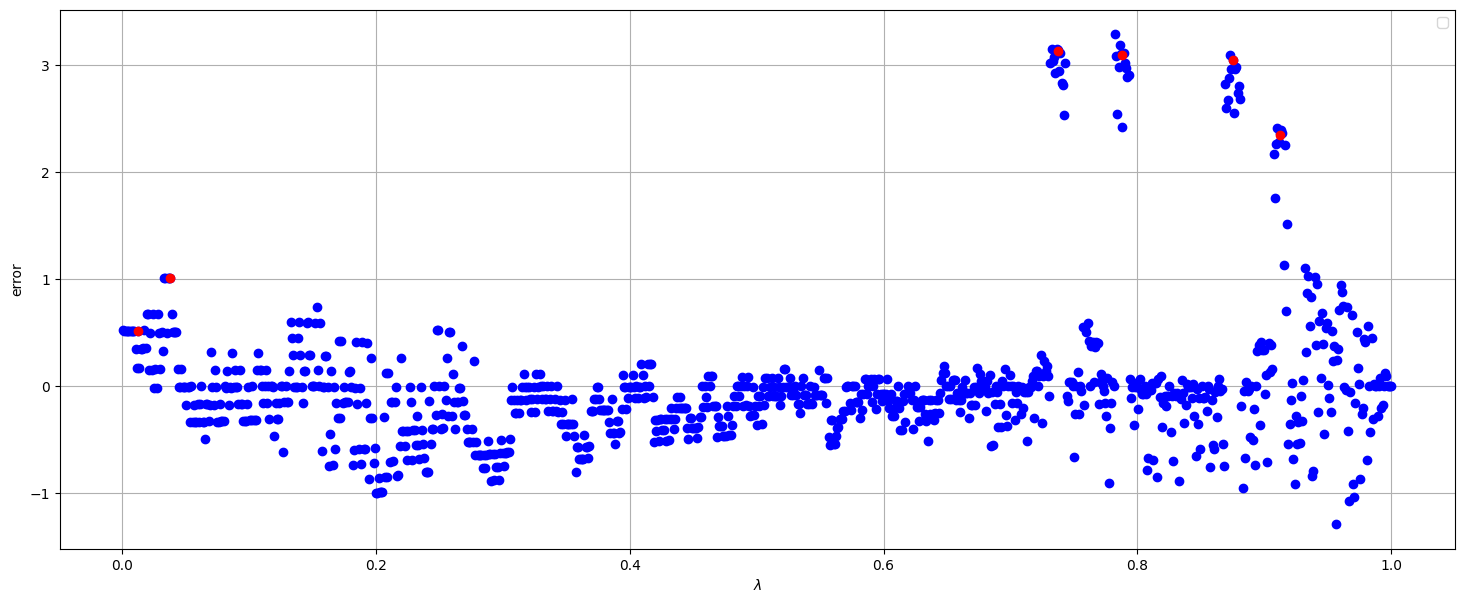

In [ ]:
# plot result of learning the solution path
plt.figure(figsize=(18,7))
plt.plot(lams, errs, 'bo')
plt.plot(failed, train_errs, 'ro')
plt.ylabel('error')
plt.xlabel('$\\lambda$')
plt.legend()
plt.grid(True)

### Archival (Ignorable for now)

@Qiran: You might find the code below useful for saving the best solution so far in SGD (SGD performance is non-monotonic).  I think (let's confirm with Paul) this is preferred to actually averaging iterates.

In [ ]:
import copy

In [ ]:
n_epochs = 100   # number of epochs to run.  Each epoch is a full pass of data
batch_size = 10  # size of each batch
batch_start = torch.arange(0, len(X), batch_size)

# Hold the best model
best_mse = np.inf   # init to infinity
best_weights = None
history = []

for epoch in range(n_epochs):
    model.train()
    with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
        bar.set_description(f"Epoch {epoch}")
        for start in bar:
            # take a batch
            X_batch = X_train[start:start+batch_size]
            y_batch = y_train[start:start+batch_size]
            # forward pass
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            # update weights
            optimizer.step()
            # print progress
            bar.set_postfix(mse=float(loss))
    # evaluate accuracy at end of each epoch
    model.eval()
    y_pred = model(X_test)
    mse = loss_fn(y_pred, y_test)
    mse = float(mse)
    history.append(mse)
    if mse < best_mse:
        best_mse = mse
        best_weights = copy.deepcopy(model.state_dict())

# restore model and return best accuracy
model.load_state_dict(best_weights)
print("MSE: %.2f" % best_mse)
print("RMSE: %.2f" % np.sqrt(best_mse))
plt.plot(history)
plt.show()